In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
!pip install gcsfs

In [4]:
# SIMPLIFIED EFFICIENT ZARR SAVING
# Focus: Proper parallelism, simple and reliable
# Removed complex auto-detection that might cause issues

import os
import time
import xarray as xr
from numcodecs import Blosc
import gcsfs

# Re-use a global filesystem client when possible
gcs = gcsfs.GCSFileSystem(project=os.getenv("GOOGLE_CLOUD_PROJECT"), token='/usr/src/app/user_id.json')
# Initialize GCS filesystem
fs = gcs # same same

def save_dataset_efficient_zarr(
    ds,
    zarr_path,
    chunk_sizes=None,
    compression='lz4',
    compression_level=1,
    overwrite=True,
    consolidated=True,
    storage='auto',
    gcs_project=None,
    align_chunks=True
):
    """
    Simplified zarr saving – focuses on reliable parallelism.

    Parameters
    ----------
    ds : xarray.Dataset
        Dataset to save (lazy dask arrays or in-memory).
    zarr_path : str
        Destination path or GCS URI (e.g. gs://bucket/path.zarr).
    chunk_sizes : dict, optional
        Chunk sizes per dimension (e.g. {'time': 20, 'x': 256, 'y': 256}).
    compression : {'lz4','blosc','zstd',None} or dict
        Built-in compressor choice or explicit encoding dict.
    compression_level : int
        Compression level (1 fastest, 9 best compression).
    overwrite : bool
        Overwrite existing zarr store.
    consolidated : bool
        Create consolidated metadata (recommended).
    storage : {'auto','local','gcs'}
        Force storage backend or infer from path when 'auto'.
    gcs_project : str, optional
        Explicit GCP project for a fresh filesystem client.

    Returns
    -------
    str
        The zarr_path that was written.
    """
    def _format_size(num_bytes: int) -> str:
        size_mb = num_bytes / (1024 * 1024)
        size_gb = size_mb / 1024
        return f"{size_gb:.2f} GB" if size_gb >= 1 else f"{size_mb:.2f} MB"

    start_time = time.time()

    storage = storage.lower()
    if storage == 'auto':
        storage = 'gcs' if zarr_path.startswith('gs://') else 'local'
    if storage not in {'local', 'gcs'}:
        raise ValueError("storage must be one of {'auto', 'local', 'gcs'}")

    fs = None
    if storage == 'gcs':
        fs = gcs if gcs_project is None else gcsfs.GCSFileSystem(project=gcs_project)
    else:
        zarr_dir = os.path.dirname(zarr_path) if os.path.dirname(zarr_path) else '.'
        if zarr_dir and not os.path.exists(zarr_dir):
            os.makedirs(zarr_dir, exist_ok=True)

    # Handle overwrite
    if storage == 'gcs':
        if fs.exists(zarr_path):
            if not overwrite:
                raise FileExistsError(
                    f"Zarr store already exists on GCS: {zarr_path}\n"
                    "Set overwrite=True to replace it."
                )
            print(f"🗑️  Removing existing GCS zarr store: {zarr_path}")
            fs.rm(zarr_path, recursive=True)
    else:
        if os.path.exists(zarr_path):
            if not overwrite:
                raise FileExistsError(
                    f"Zarr store already exists: {zarr_path}\n"
                    "Set overwrite=True to replace it."
                )
            import shutil
            print(f"🗑️  Removing existing zarr store: {zarr_path}")
            shutil.rmtree(zarr_path)

    # Default chunk sizes
    if chunk_sizes is None:
        chunk_sizes = {}
        dims = ds.dims
        if 'time' in dims:
            chunk_sizes['time'] = min(20, dims['time'])
        if 'x' in dims:
            chunk_sizes['x'] = min(256, dims['x'])
        if 'y' in dims:
            chunk_sizes['y'] = min(256, dims['y'])
        for dim_name, dim_len in dims.items():
            chunk_sizes.setdefault(dim_name, min(100, dim_len))

    print(f"📦 Saving to zarr: {zarr_path}")
    print(f"   Dimensions: {dict(ds.dims)}")
    print(f"   Chunks: {chunk_sizes}")
    print(f"   Compression: {compression} (level {compression_level})")
    print(f"   Storage: {storage}")

    # Prepare compression
    if compression == 'lz4':
        compressor = Blosc(cname='lz4', clevel=compression_level, shuffle=Blosc.SHUFFLE, blocksize=0)
        encoding = {var: {'compressor': compressor} for var in ds.data_vars}
    elif compression == 'blosc':
        compressor = Blosc(cname='blosclz', clevel=compression_level, shuffle=Blosc.SHUFFLE, blocksize=0)
        encoding = {var: {'compressor': compressor} for var in ds.data_vars}
    elif compression == 'zstd':
        compressor = Blosc(cname='zstd', clevel=compression_level, shuffle=Blosc.SHUFFLE, blocksize=0)
        encoding = {var: {'compressor': compressor} for var in ds.data_vars}
    elif compression is None:
        encoding = {}
    else:
        encoding = compression  # assume dict supplied

    # Chunk and save
    ds_chunked = ds.chunk(chunk_sizes)
    print("💾 Writing to zarr (with automatic parallelism)...")

    store = fs.get_mapper(zarr_path) if storage == 'gcs' else zarr_path
    try:
        from dask.diagnostics import ProgressBar
        with ProgressBar():
            ds_chunked.to_zarr(
                store,
                mode='w',
                encoding=encoding,
                consolidated=consolidated,
                compute=True,
                zarr_version=2,  # ADD THIS LINE
                align_chunks=align_chunks
            )
    except ImportError:
        ds_chunked.to_zarr(
            store,
            mode='w',
            encoding=encoding,
            consolidated=consolidated,
            compute=True,
            zarr_version=2,  # ADD THIS LINE
            align_chunks=align_chunks
        )

    elapsed = time.time() - start_time

    # Size reporting
    total_size = None
    if storage == 'gcs':
        try:
            size_info = fs.du(zarr_path)
            if isinstance(size_info, dict):
                total_size = sum(size_info.values())
            elif isinstance(size_info, (int, float)):
                total_size = size_info
        except Exception as exc:
            print(f"⚠️  Could not compute GCS store size: {exc}")
    else:
        if os.path.exists(zarr_path):
            total_size = 0
            for dirpath, _, filenames in os.walk(zarr_path):
                for f in filenames:
                    fp = os.path.join(dirpath, f)
                    total_size += os.path.getsize(fp)

    if total_size is not None:
        size_str = _format_size(total_size)
        write_speed = total_size / elapsed / (1024 * 1024)
        print("✅ Dataset saved successfully!")
        print(f"   Store size: {size_str}")
        print(f"   Time: {elapsed:.1f} seconds ({elapsed/60:.1f} minutes)")
        print(f"   Write speed: {write_speed:.1f} MB/s")
        print(f"   Path: {zarr_path}")
    else:
        print("✅ Dataset saved successfully! (size unavailable)")
        print(f"   Time: {elapsed:.1f} seconds ({elapsed/60:.1f} minutes)")
        print(f"   Path: {zarr_path}")

    return zarr_path


def load_dataset_zarr(zarr_path, consolidated=True, storage='auto', gcs_project=None):
    """
    Load a dataset from a zarr store located locally or on GCS.
    """
    storage = storage.lower()
    if storage == 'auto':
        storage = 'gcs' if zarr_path.startswith('gs://') else 'local'
    if storage not in {'local', 'gcs'}:
        raise ValueError("storage must be one of {'auto', 'local', 'gcs'}")

    if storage == 'gcs':
        fs = gcs if gcs_project is None else gcsfs.GCSFileSystem(project=gcs_project)
        if not fs.exists(zarr_path):
            raise FileNotFoundError(f"Zarr store not found on GCS: {zarr_path}")
        mapper = fs.get_mapper(zarr_path)
        print(f"📂 Loading dataset from GCS zarr: {zarr_path}")
        ds = xr.open_zarr(mapper, consolidated=consolidated)
    else:
        if not os.path.exists(zarr_path):
            raise FileNotFoundError(f"Zarr store not found: {zarr_path}")
        print(f"📂 Loading dataset from zarr: {zarr_path}")
        ds = xr.open_zarr(zarr_path, consolidated=consolidated)

    print(f"✅ Dataset loaded: {dict(ds.dims)}")
    return ds


print("✅ Simplified zarr saving functions loaded!")
print("\nKey simplifications:")
print("  - No complex auto-detection")
print("  - Always uses compute=True (let dask handle parallelism)")
print("  - Simple, reliable, focuses on parallelism")
print("  - Works with both lazy and in-memory arrays")


✅ Simplified zarr saving functions loaded!

Key simplifications:
  - No complex auto-detection
  - Always uses compute=True (let dask handle parallelism)
  - Simple, reliable, focuses on parallelism
  - Works with both lazy and in-memory arrays


In [4]:
zarr_path = os.getenv('GCS_ZARR_DIR') + '/ds_resampled.zarr'
# zarr_path = 'data/ds_resampled.zarr'
# storage = 'local'
storage = 'gcs'

ds_resampled = load_dataset_zarr(zarr_path, storage=storage)
ds_resampled


📂 Loading dataset from GCS zarr: gs://remote_sensing_saas/01-korindo/timeseries_zarr/ds_resampled.zarr
✅ Dataset loaded: {'time': 81, 'x': 4489, 'y': 3213}


/tmp/ipykernel_630/3039169824.py:218: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(f"✅ Dataset loaded: {dict(ds.dims)}")


<xarray.Dataset> Size: 9GB
Dimensions:   (time: 81, x: 4489, y: 3213)
Coordinates:
    image_id  (time) <U17 6kB dask.array<chunksize=(40,), meta=np.ndarray>
  * time      (time) datetime64[ns] 648B 2018-02-15 2018-05-15 ... 2025-08-15
  * x         (x) float64 36kB 5.786e+05 5.786e+05 ... 6.235e+05 6.235e+05
  * y         (y) float64 26kB 9.949e+06 9.949e+06 ... 9.982e+06 9.982e+06
Data variables:
    EVI       (time, x, y) float32 5GB dask.array<chunksize=(40, 1024, 1024), meta=np.ndarray>
    NDVI      (time, x, y) float32 5GB dask.array<chunksize=(40, 1024, 1024), meta=np.ndarray>
Attributes:
    crs:      EPSG:32749

In [5]:
print(ds_resampled)

<xarray.Dataset> Size: 9GB
Dimensions:   (time: 81, x: 4489, y: 3213)
Coordinates:
    image_id  (time) <U17 6kB dask.array<chunksize=(40,), meta=np.ndarray>
  * time      (time) datetime64[ns] 648B 2018-02-15 2018-05-15 ... 2025-08-15
  * x         (x) float64 36kB 5.786e+05 5.786e+05 ... 6.235e+05 6.235e+05
  * y         (y) float64 26kB 9.949e+06 9.949e+06 ... 9.982e+06 9.982e+06
Data variables:
    EVI       (time, x, y) float32 5GB dask.array<chunksize=(40, 1024, 1024), meta=np.ndarray>
    NDVI      (time, x, y) float32 5GB dask.array<chunksize=(40, 1024, 1024), meta=np.ndarray>
Attributes:
    crs:      EPSG:32749


In [6]:
crs_ds = ds_resampled.attrs.get('crs')

In [7]:
# crs_ds = 'EPSG:32749'

In [ ]:
def standardize_to_stac_convention(ds):
    """
    Standardize xarray Dataset to STAC convention:
    - Y coordinates descending (maxy to miny)
    - X coordinates ascending (minx to maxx)
    
    Parameters:
    -----------
    ds : xarray.Dataset
        Dataset to standardize
    
    Returns:
    --------
    ds : xarray.Dataset
        Standardized dataset
    """
    ds = ds.copy()
    
    # Check and fix y coordinates
    y_values = ds.y.values
    if y_values[0] < y_values[-1]:  # Ascending - need to reverse
        print("Reversing y dimension to STAC convention...")
        ds = ds.reindex(y=ds.y[::-1])
    
    # Check and fix x coordinates (should be ascending)
    x_values = ds.x.values
    if x_values[0] > x_values[-1]:  # Descending - need to reverse
        print("Reversing x dimension to standard convention...")
        ds = ds.reindex(x=ds.x[::-1])
    
    # Verify
    y_final = ds.y.values
    x_final = ds.x.values
    
    y_stac = y_final[0] > y_final[-1]
    x_std = x_final[0] < x_final[-1]
    
    if y_stac and x_std:
        print("✓ Dataset standardized to STAC convention")
    else:
        print("⚠️  Warning: Standardization may not be complete")
        print(f"  Y descending: {y_stac}, X ascending: {x_std}")
    
    return ds

# Usage: this one to make it the same selection of clip, like in STAC (maxy,miny)
ds_resampled = standardize_to_stac_convention(ds_resampled)

Reversing y dimension to STAC convention...
✓ Dataset standardized to STAC convention


In [5]:
#### DS TRAIN CHECK RESAMPLING
import os
import geopandas as gpd
import pandas as pd
import gcsfs

path_training = '00_input/training_shp/'

layers = [shp for shp in os.listdir(path_training) if shp.endswith('.shp') and shp.startswith('sample')]
gcs_path = f'gs://{os.getenv("GCS_BUCKET_PATH")}/01-korindo/sample_tsfresh/20251112_training_gdf_col_filtered.parquet'

use_parquet_training = True

if use_parquet_training != True:
    gdf_list = []

    for lyr in layers:
        print(lyr)
        gdf = gpd.read_file(os.path.join(path_training,lyr))
        gdf['layer'] = lyr.replace('.shp', '')
        print(gdf.crs)
        print('check size, if too big, you need to recheck: ',gdf.shape)
        gdf_utm = gdf.to_crs(crs_ds)       
        print('transforming to crs: ',gdf_utm.crs)

        # data dissolve to clean, if the data is too big, use ArcGIS or QGIS instead
        list_columns_time = [i for i in gdf_utm.columns if i.startswith('t_') and not i.endswith('D')]
        gdf_utm = gdf_utm.dissolve(by=['layer']+list_columns_time)
        gdf_utm = gdf_utm.reset_index()
        gdf_list.append(gdf_utm)

    training_gdf = gpd.GeoDataFrame(pd.concat(gdf_list, ignore_index=True))
    # training_gdf = gpd.read_file('00_input/training_shp/sample_1.shp')
    # training_gdf.head()
    # training_gdf.head()

    # training_gdf.crs

    # training_gdf.geometry.head()
    # training_gdf.columns

    list_columns_time = [i for i in training_gdf.columns if i.startswith('t_') and not i.endswith('D')]
    list_columns_time = list(sorted(list_columns_time))
    # list_columns_time

    columns_filter = ['layer'] + list_columns_time + ['geometry']

    training_gdf_col_filtered = training_gdf[columns_filter]
    # training_gdf_col_filtered = training_gdf_col_filtered.dissolve(by=['layer']+list_columns_time)
    # training_gdf_col_filtered = training_gdf_col_filtered.reset_index()
    # training_gdf_col_filtered.head()
    # training_gdf_col_filtered.plot()

    # Save as GeoParquet (BEST option)
    gcs_path = gcs_path    
    training_gdf_col_filtered.to_parquet(gcs_path, filesystem=fs, compression='snappy')

else:
    training_gdf_col_filtered = gpd.read_parquet(gcs_path, filesystem=fs)
print('final shape: ',training_gdf_col_filtered.shape)


final shape:  (78, 71)


In [6]:
# for i in training_gdf.columns:
#     print(i)
# # training_gdf_col_filtered.head()

In [7]:
training_gdf_col_filtered.head()

,layer,t_201603,t_201606,t_201609,t_201612,t_201703,t_201706,t_201709,t_201712,t_201803,...,t_202501,t_202502,t_202503,t_202504,t_202505,t_202506,t_202507,t_202508,t_202509,geometry
0,sample_2,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,"MULTIPOLYGON (((592439.970 9950624.446, 592472..."
1,sample_2,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,"POLYGON ((591963.540 9951127.666, 591985.528 9..."
2,sample_2,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,"MULTIPOLYGON (((592062.841 9950226.187, 592071..."
3,sample_2,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,"MULTIPOLYGON (((590310.884 9951179.496, 590319..."
4,sample_2,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,"POLYGON ((590565.026 9950696.784, 590564.841 9..."


In [21]:
# ### TAKES TIME FOR THIS GEE since we will upload data to GEE
# # import os
# import ee
# # import geemap.foliumap as geemap

# service_account = os.getenv('SERVICE_ACCOUNT')
# key_path = '/usr/src/app/user_id.json'

# credentials = ee.ServiceAccountCredentials(service_account, key_path)
# ee.Initialize(credentials)

# # gdf_wgs84 = training_gdf_col_filtered.to_crs(epsg=4326)

# # centroid = gdf_wgs84.geometry.centroid.unary_union.centroid
# # m = geemap.Map(center=[centroid.y, centroid.x], zoom=9, ee_initialize=False)
# # m.add_gdf(gdf_wgs84, layer_name="training_gdf_col_filtered")
# # m

In [22]:
# training_gdf_col_filtered.to_file("00_input/training_shp/training_gdf_col_filtered_4326.shp") # local non gcs parquet

In [23]:
##no need to plot for the second time if the data is the same
# Quick plot (very fast)
# from matplotlib import pyplot as plt

# training_gdf_col_filtered.plot(figsize=(12, 10), markersize=0.5)
# plt.title(f"Training Data ({len(training_gdf_col_filtered):,} features)")
# plt.show()

In [24]:
# ## lets load in wmts from gdf, its LOADING TOO SLOW TO LOAD AS THE GDF IF LOAD FROM WFS ee.featureCollection
# gdf_wgs84 = training_gdf_col_filtered.to_crs(epsg=4326)

# #### wmts loading
# from wfs_manager import WFSManager
# import geemap

# fc = geemap.gdf_to_ee(gdf_wgs84)

# wfs = WFSManager(fastapi_url="http://fastapi:8000", wfs_base_url="http://localhost:8001")
# wfs.addLayer(fc, "Training data collected")
# wfs.publish()

In [25]:
# training_gdf_col_filtered.columns

In [ ]:
import pandas as pd
import geopandas as gpd

use_existing_df_long = True
gcs_path_df_long = f'gs://{os.getenv("GCS_BUCKET_PATH")}/01-korindo/sample_tsfresh/20251112_df_long.parquet'

if use_existing_df_long != True:
    # training_gdf_col_filtered

    t_cols = [col for col in training_gdf_col_filtered.columns if col.startswith('t_')]

    # Melt the dataframe with geometry as id_var
    df_long = pd.melt(
        training_gdf_col_filtered, 
        id_vars=['layer','geometry'],
        value_vars=t_cols,
        var_name='time_period',
        value_name='value'
    )

    # Set geometry as index
    # df_long = df_long.set_index('geometry')

    print(f"Original shape: {training_gdf_col_filtered.shape}")
    print(f"Long format shape: {df_long.shape}")
    print(f"Time columns found: {len(t_cols)}")
    # print(f"\nFirst few rows:")
    # df_long.head()
    # df_long.layer.unique()

    # df_long.reset_index(inplace=True)
    # df_long.head()

    ## reformating the column (date)
    df_long = df_long.rename(columns={'value': 'type'})
    df_long['date'] = df_long['time_period'].str[2:].astype(int)
    # df_long.head()

    # type(df_long)

    training_gdf = df_long.copy()
    # Remove multipolygons
    training_gdf = training_gdf.explode(index_parts=False)
    print(training_gdf.crs)

    ##### conversion
    # Drop rows where 'type' is NA
    training_gdf = training_gdf.copy()
    training_gdf = training_gdf.dropna(subset=['type'])
    # training_gdf['date'] = pd.to_datetime(training_gdf['date'], format='%Y%m')
    # training_gdf['date'] = pd.to_datetime(training_gdf['date'], format='%Y%m') + pd.offsets.MonthEnd(0)
    # Middle of month (day 15)
    training_gdf['date'] = pd.to_datetime(training_gdf['date'], format='%Y%m') + pd.Timedelta(days=14)

    # add year columnt
    training_gdf['year'] = training_gdf['date'].dt.year

    # convert column 'type' from string to int
    training_gdf['type'] = training_gdf['type'].astype(int)
    print('shape of training_gdf after drop NA:', training_gdf.shape)
    
    training_gdf.to_parquet(gcs_path_df_long, filesystem=fs, compression='snappy')

else:
    training_gdf = gpd.read_parquet(gcs_path_df_long, filesystem=fs)


In [38]:
training_gdf

,layer,time_period,type,date,geometry,year
18,sample_3,t_201603,1,2016-03-15,"POLYGON ((583535.757 9968378.321, 583550.787 9...",2016
18,sample_3,t_201603,1,2016-03-15,"POLYGON ((584091.223 9968586.585, 584074.687 9...",2016
18,sample_3,t_201603,1,2016-03-15,"POLYGON ((585516.209 9969290.123, 585522.369 9...",2016
18,sample_3,t_201603,1,2016-03-15,"POLYGON ((585164.625 9969775.844, 585188.675 9...",2016
18,sample_3,t_201603,1,2016-03-15,"POLYGON ((584320.553 9969896.846, 584279.966 9...",2016
...,...,...,...,...,...,...
5381,sample_1,t_202509,1,2025-09-15,"POLYGON ((589746.634 9954628.153, 589737.212 9...",2025
5381,sample_1,t_202509,1,2025-09-15,"POLYGON ((589519.010 9954664.900, 589503.063 9...",2025
5381,sample_1,t_202509,1,2025-09-15,"POLYGON ((590849.731 9953660.675, 590856.576 9...",2025
5381,sample_1,t_202509,1,2025-09-15,"POLYGON ((591363.156 9954414.545, 591349.013 9...",2025


In [39]:
display(training_gdf.head())
print(training_gdf.shape)

,layer,time_period,type,date,geometry,year
18,sample_3,t_201603,1,2016-03-15,"POLYGON ((583535.757 9968378.321, 583550.787 9...",2016
18,sample_3,t_201603,1,2016-03-15,"POLYGON ((584091.223 9968586.585, 584074.687 9...",2016
18,sample_3,t_201603,1,2016-03-15,"POLYGON ((585516.209 9969290.123, 585522.369 9...",2016
18,sample_3,t_201603,1,2016-03-15,"POLYGON ((585164.625 9969775.844, 585188.675 9...",2016
18,sample_3,t_201603,1,2016-03-15,"POLYGON ((584320.553 9969896.846, 584279.966 9...",2016


(7470, 6)


<Axes: >

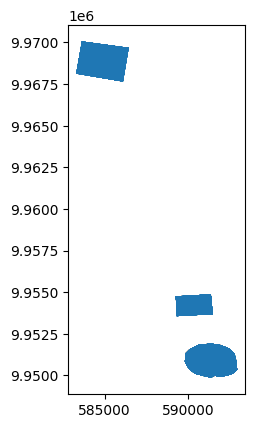

In [40]:
# test = 't_202509'
# test[2:]

training_gdf.plot()

In [46]:
# training_gdf['date']

In [47]:
# training_gdf['year']

In [48]:
## to minimize the ram usage, we can delete the ram usage to variables
# del training_gdf_col_filtered
# del df_long


In [16]:
training_gdf_col_filtered.t_201612.isna().sum()

0

In [18]:
training_gdf_col_filtered.columns

Index(['layer', 't_201603', 't_201606', 't_201609', 't_201612', 't_201703',
       't_201706', 't_201709', 't_201712', 't_201803', 't_201806', 't_201809',
       't_201812', 't_201903', 't_201906', 't_201909', 't_201912', 't_202003',
       't_202006', 't_202009', 't_202012', 't_202103', 't_202106', 't_202109',
       't_202112', 't_202201', 't_202202', 't_202203', 't_202204', 't_202205',
       't_202206', 't_202207', 't_202208', 't_202209', 't_202210', 't_202211',
       't_202212', 't_202301', 't_202302', 't_202303', 't_202304', 't_202305',
       't_202306', 't_202307', 't_202308', 't_202309', 't_202310', 't_202311',
       't_202312', 't_202401', 't_202402', 't_202403', 't_202404', 't_202405',
       't_202406', 't_202407', 't_202408', 't_202409', 't_202410', 't_202411',
       't_202412', 't_202501', 't_202502', 't_202503', 't_202504', 't_202505',
       't_202506', 't_202507', 't_202508', 't_202509', 'geometry'],
      dtype='object')

In [20]:
max_month_yearly_list

[12, 12, 12, 12, 12, 12, 12, 12, 12, 9]

In [35]:
import re

# GET THE ANNUAL MAX MONTH AND YEARLY GROUNDTRUTH
yearm_list = [col for col in training_gdf_col_filtered.columns if col.startswith('t_') and not col.endswith('D')]
yearlist = list(sorted(set([int(col.split('_')[-1][:4]) for col in yearm_list])))
max_month_yearly_list = []
for year in yearlist:
    max_month_yearly_list.append(max([int(col.split('_')[-1][4:]) for col in yearm_list if year == int(col.split('_')[-1][:4])]))

max_annual_filter_fields = [f't_{year}{max_month_yearly_list[i]:02d}' for i, year in enumerate(yearlist)]

# yearly - use .copy() to avoid SettingWithCopyWarning
training_gdf_col_filtered_annually = training_gdf_col_filtered[['layer']+max_annual_filter_fields + ['geometry']].copy()

t_cols = [col for col in training_gdf_col_filtered_annually.columns if col.startswith('t_') and not col.endswith('D')]

# Extract year for sorting
def get_year(col):
    match = re.match(r't_(\d{4})(\d{2})', col)
    return int(match.group(1)) if match else 0

# Sort by year (ascending)
t_cols_sorted = sorted(t_cols, key=get_year)

# Forward fill: fill NaN with previous year's value using .loc to avoid warning
for i in range(1, len(t_cols_sorted)):
    current_col = t_cols_sorted[i]
    prev_col = t_cols_sorted[i-1]
    mask = training_gdf_col_filtered_annually[current_col].isna()
    training_gdf_col_filtered_annually.loc[mask, current_col] = training_gdf_col_filtered_annually.loc[mask, prev_col]

training_gdf_col_filtered_annually.head()

,layer,t_201612,t_201712,t_201812,t_201912,t_202012,t_202112,t_202212,t_202312,t_202412,t_202509,geometry
0,sample_2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"MULTIPOLYGON (((592439.970 9950624.446, 592472..."
1,sample_2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((591963.540 9951127.666, 591985.528 9..."
2,sample_2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,"MULTIPOLYGON (((592062.841 9950226.187, 592071..."
3,sample_2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"MULTIPOLYGON (((590310.884 9951179.496, 590319..."
4,sample_2,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,"POLYGON ((590565.026 9950696.784, 590564.841 9..."


In [40]:
training_gdf_col_filtered_annually.to_file('01_output/training_gdf_col_filtered_annually.geojson', driver='GeoJSON')

In [36]:
training_gdf_col_filtered_annually.to_file('01_output/training_gdf_col_filtered_annually.geojson', driver='GeoJSON')


In [37]:
training_gdf_col_filtered_annually.shape

(78, 12)

In [39]:
# training gdf yearly
import pandas as pd
import geopandas as gpd

use_existing_df_long = False
gcs_path_df_long = f'gs://{os.getenv("GCS_BUCKET_PATH")}/01-korindo/sample_tsfresh/20251125_df_long_yearly.parquet'

if use_existing_df_long != True:
    # training_gdf_col_filtered_annually

    t_cols = [col for col in training_gdf_col_filtered_annually.columns if col.startswith('t_')]

    # Melt the dataframe with geometry as id_var
    df_long = pd.melt(
        training_gdf_col_filtered_annually, 
        id_vars=['layer','geometry'],
        value_vars=t_cols,
        var_name='time_period',
        value_name='value'
    )

    # Set geometry as index
    # df_long = df_long.set_index('geometry')

    print(f"Original shape: {training_gdf_col_filtered_annually.shape}")
    print(f"Long format shape: {df_long.shape}")
    print(f"Time columns found: {len(t_cols)}")
    # print(f"\nFirst few rows:")
    # df_long.head()
    # df_long.layer.unique()

    # df_long.reset_index(inplace=True)
    # df_long.head()

    ## reformating the column (date)
    df_long = df_long.rename(columns={'value': 'type'})
    df_long['date'] = df_long['time_period'].str[2:].astype(int)
    # df_long.head()

    # type(df_long)

    training_gdf = df_long.copy()
    # Remove multipolygons
    training_gdf = training_gdf.explode(index_parts=False)
    print(training_gdf.crs)

    ##### conversion
    # Drop rows where 'type' is NA
    training_gdf = training_gdf.copy()
    # Get time columns (t_* not ending with D)

    training_gdf['date'] = pd.to_datetime(training_gdf['date'], format='%Y%m')
    # training_gdf['date'] = pd.to_datetime(training_gdf['date'], format='%Y%m') + pd.offsets.MonthEnd(0)
    #end of the year - normalized for input raster later (e.g FCD) - this is annual data
    training_gdf['date'] = training_gdf['date'].apply(lambda x: x.replace(month=12,day=31))

    # add year columnt
    training_gdf['year'] = training_gdf['date'].dt.year

    # convert column 'type' from string to int
    training_gdf['type'] = training_gdf['type'].astype(int)
    print('shape of training_gdf:', training_gdf.shape)
    
    training_gdf.to_parquet(gcs_path_df_long, filesystem=fs, compression='snappy')

else:
    training_gdf = gpd.read_parquet(gcs_path_df_long, filesystem=fs)


Original shape: (78, 12)
Long format shape: (780, 4)
Time columns found: 10
{"$schema": "https://proj.org/schemas/v0.7/projjson.schema.json", "type": "ProjectedCRS", "name": "WGS 84 / UTM zone 49S", "base_crs": {"name": "WGS 84", "datum_ensemble": {"name": "World Geodetic System 1984 ensemble", "members": [{"name": "World Geodetic System 1984 (Transit)"}, {"name": "World Geodetic System 1984 (G730)"}, {"name": "World Geodetic System 1984 (G873)"}, {"name": "World Geodetic System 1984 (G1150)"}, {"name": "World Geodetic System 1984 (G1674)"}, {"name": "World Geodetic System 1984 (G1762)"}, {"name": "World Geodetic System 1984 (G2139)"}], "ellipsoid": {"name": "WGS 84", "semi_major_axis": 6378137, "inverse_flattening": 298.257223563}, "accuracy": "2.0", "id": {"authority": "EPSG", "code": 6326}}, "coordinate_system": {"subtype": "ellipsoidal", "axis": [{"name": "Geodetic latitude", "abbreviation": "Lat", "direction": "north", "unit": "degree"}, {"name": "Geodetic longitude", "abbreviatio

In [49]:
# ============================================================================
# STEP 1: IMPORT REQUIRED LIBRARIES
# ============================================================================
from multiprocessing import Pool  # For parallel processing (running multiple tasks at once)
from functools import partial     # For creating functions with pre-filled arguments
import xarray as xr              # For working with multi-dimensional arrays (like netCDF, zarr)
import numpy as np               # For numerical operations
import pandas as pd              # For data manipulation
import multiprocessing as mp     # For getting CPU count

# ============================================================================
# STEP 2: DEFINE FUNCTION TO CREATE MASK FOR ONE DATE-LAYER COMBINATION
# ============================================================================
def get_raster_mask_with_layer(date_layer_tuple, ds, gdf_1_dissolved, gdf_0_dissolved):
    """
    Creates a raster mask from vector polygons for a specific date and layer.
    
    What this does:
    - Takes polygons (shapes) from your training data
    - Converts them into a grid (raster) matching your satellite data
    - Assigns value 1 for tree areas, 0 for non-tree areas, NaN for no data
    
    Parameters:
    -----------
    date_layer_tuple : tuple (date, layer)
        The specific date and layer (e.g., 'sample_1') to process
    ds : xarray.Dataset
        Your satellite dataset (to match grid size and coordinates)
    gdf_1_dissolved : GeoDataFrame
        Pre-processed polygons for tree areas (type=1)
    gdf_0_dissolved : GeoDataFrame
        Pre-processed polygons for non-tree areas (type=0)
    
    Returns:
    --------
    mask_da : xarray.DataArray
        A grid with 1s (trees), 0s (non-trees), and NaN (no label)
    """
    import numpy as np
    import rasterio.features  # For converting vector shapes to raster grids
    from affine import Affine  # For coordinate transformations
    
    # --- Unpack the date and layer from input tuple ---
    date, layer = date_layer_tuple
    
    # --- Filter polygons for this specific date and layer ---
    # MultiIndex means the index has multiple levels (date AND layer)
    # We need to match BOTH date and layer to get the right polygons
    trees = gdf_1_dissolved[
        (gdf_1_dissolved.index.get_level_values('date') == date) & 
        (gdf_1_dissolved.index.get_level_values('layer') == layer)
    ]
    non_trees = gdf_0_dissolved[
        (gdf_0_dissolved.index.get_level_values('date') == date) & 
        (gdf_0_dissolved.index.get_level_values('layer') == layer)
    ]
    
    # --- Prepare features for rasterization ---
    # Features are tuples of (geometry, value)
    # All tree geometries get value 1, all non-tree geometries get value 0
    features = [(geom, 1) for geom in trees.geometry] + \
               [(geom, 0) for geom in non_trees.geometry]
    
    # --- Get the grid dimensions from your satellite dataset ---
    x = ds.coords['x'].values  # X coordinates (longitude-like)
    y = ds.coords['y'].values  # Y coordinates (latitude-like)
    
    # --- Handle case where there are no training labels for this date-layer ---
    if not features:
        # Create an empty grid filled with NaN (no data)
        mask_raster = np.full((len(y), len(x)), np.nan, dtype="float32")
    else:
        # --- Calculate pixel resolution (size of each grid cell) ---
        # Resolution is the distance between adjacent pixels
        res_x = (x[-1] - x[0]) / (len(x) - 1)  # Horizontal resolution
        res_y = (y[0] - y[-1]) / (len(y) - 1)  # Vertical resolution
        
        # --- Create affine transformation ---
        # This tells rasterio how to map real-world coordinates to pixel indices
        # Translation: moves origin to top-left corner of top-left pixel
        # Scale: defines pixel size (negative y because images start from top)
        transform = Affine.translation(x[0] - res_x / 2, y[0] + res_y / 2) * \
                   Affine.scale(res_x, -res_y)
        
        # --- Rasterize: convert vector polygons to raster grid ---
        mask_raster = rasterio.features.rasterize(
            features,              # List of (geometry, value) tuples
            out_shape=(len(y), len(x)),  # Output grid size
            transform=transform,   # Coordinate transformation
            fill=np.nan,          # Value for pixels outside all polygons
            dtype="float32"       # Data type (float to allow NaN)
        )
    
    # --- Wrap the numpy array in an xarray DataArray ---
    # This adds coordinate labels and metadata to the grid
    mask_da = xr.DataArray(
        mask_raster,              # The actual data (2D grid)
        dims=("y", "x"),         # Dimension names
        coords={
            "y": ds.coords["y"],  # Y coordinate values
            "x": ds.coords["x"],  # X coordinate values
            "date": date,         # Date as scalar coordinate
            "layer": layer        # Layer as scalar coordinate
        },
    )
    
    return mask_da


# ============================================================================
# STEP 3: DEFINE FUNCTION FOR PARALLEL PROCESSING
# ============================================================================
def parallel_rasterize_with_layer(date_layer_combinations, ds, gdf_1_dissolved, 
                                   gdf_0_dissolved, n_workers=4):
    """
    Process multiple date-layer combinations in parallel (at the same time).
    
    Why parallel?
    - Instead of processing dates one by one (slow), we process multiple at once
    - Uses multiple CPU cores to speed up computation
    - Example: 4 workers = ~4x faster for independent tasks
    
    Parameters:
    -----------
    date_layer_combinations : list of tuples
        All (date, layer) pairs to process
    ds : xarray.Dataset
        Your satellite dataset
    gdf_1_dissolved, gdf_0_dissolved : GeoDataFrames
        Pre-processed training polygons
    n_workers : int
        Number of parallel processes (usually = number of CPU cores)
    
    Returns:
    --------
    masks : list of xarray.DataArray
        One mask for each date-layer combination
    """
    # --- Create a partial function with pre-filled arguments ---
    # This is needed because pool.map() can only pass one argument
    # We "freeze" ds, gdf_1_dissolved, gdf_0_dissolved so only date_layer changes
    func = partial(
        get_raster_mask_with_layer, 
        ds=ds, 
        gdf_1_dissolved=gdf_1_dissolved,
        gdf_0_dissolved=gdf_0_dissolved
    )
    
    # --- Create a pool of worker processes and run in parallel ---
    with Pool(n_workers) as pool:
        masks = pool.map(func, date_layer_combinations)
    
    return masks

In [58]:
ds_resampled

<xarray.Dataset> Size: 9GB
Dimensions:   (time: 81, x: 4489, y: 3213)
Coordinates:
  * time      (time) datetime64[ns] 648B 2018-02-15 2018-05-15 ... 2025-08-15
  * x         (x) float64 36kB 5.786e+05 5.786e+05 ... 6.235e+05 6.235e+05
  * y         (y) float64 26kB 9.982e+06 9.982e+06 ... 9.949e+06 9.949e+06
    image_id  (time) <U17 6kB dask.array<chunksize=(40,), meta=np.ndarray>
Data variables:
    EVI       (time, x, y) float32 5GB dask.array<chunksize=(40, 1024, 803), meta=np.ndarray>
    NDVI      (time, x, y) float32 5GB dask.array<chunksize=(40, 1024, 803), meta=np.ndarray>
Attributes:
    crs:      EPSG:32749

In [55]:
# ============================================================================
# STEP 5: ORGANIZE MASKS INTO A 4D DATASET: PLOT, TIME, Y, X
# ============================================================================
def merge_all_masks_4d(masks, epsg=32749):
    """
    Merge masks with plot_id as a dimension from the start.
    Dimensions: (plot_id, time, y, x)
    Coordinates: (plot_id, time, y, x, epsg as auxiliary)
    """
    import pandas as pd
    import numpy as np
    import dask.array as da
    
    # Collect all dates and plots
    date_plot_pairs = []
    
    for mask in masks:
        date = pd.Timestamp(mask.coords['date'].values)
        layer = mask.coords['layer'].values.item()
        date_plot_pairs.append((date, layer, mask))
    
    # Get unique plots and times
    unique_plots = sorted(set([plot for _, plot, _ in date_plot_pairs]))
    unique_times = sorted(set([date for date, _, _ in date_plot_pairs]))
    
    print(f"Organizing into 4D dataset:")
    print(f"  {len(masks)} total date-layer combinations")
    print(f"  {len(unique_plots)} unique plots")
    print(f"  {len(unique_times)} unique times")
    print(f"  Target dimensions: (plot_id, time, y, x)")
    
    # Build dict of plot -> time -> mask
    plot_time_masks = {}
    for date, plot_id, mask_orig in date_plot_pairs:
        if plot_id not in plot_time_masks:
            plot_time_masks[plot_id] = {}
        
        # Clean and make lazy
        mask_clean = mask_orig.drop_vars(['date', 'layer'], errors='ignore')
        if not isinstance(mask_clean.data, da.Array):
            mask_clean = mask_clean.chunk({'y': 512, 'x': 512})
        
        plot_time_masks[plot_id][date] = mask_clean
    
    print("  ✓ Prepared masks as dask arrays (lazy)")
    
    # Get spatial dimensions from first mask
    first_mask = masks[0].drop_vars(['date', 'layer'], errors='ignore')
    y_coords = first_mask.y.values
    x_coords = first_mask.x.values
    
    # Create list of DataArrays for each plot
    print("  Creating 4D structure...")
    plot_arrays = []
    
    for plot_id in unique_plots:
        time_arrays = []
        for time in unique_times:
            if time in plot_time_masks[plot_id]:
                time_arrays.append(plot_time_masks[plot_id][time])
            else:
                # Create NaN-filled dask array for missing time
                nan_shape = (len(y_coords), len(x_coords))
                nan_dask = da.full(nan_shape, np.nan, dtype='float32', chunks=(512, 512))
                nan_array = xr.DataArray(
                    nan_dask,
                    dims=['y', 'x'],
                    coords={'y': y_coords, 'x': x_coords}
                )
                time_arrays.append(nan_array)
        
        # Concatenate along time for this plot (lazy)
        plot_array = xr.concat(time_arrays, dim='time')
        plot_arrays.append(plot_array)
        print(f"    {plot_id}: {len(time_arrays)} times", end='\r')
    
    print("\n  ✓ Built plot-time structure")
    
    # Concatenate along plot dimension (still lazy)
    print("  Concatenating plots...")
    combined = xr.concat(plot_arrays, dim='plot_id')
    
    # Assign coordinates in desired order
    combined = combined.assign_coords({
        'plot_id': unique_plots,
        'time': unique_times,
        'y': y_coords,
        'x': x_coords,
        'epsg': np.int64(epsg) 
    })
    
    # Transpose to desired order: (plot_id, time, y, x)
    combined = combined.transpose('plot_id', 'time', 'y', 'x')
    
    # Create Dataset
    gt = xr.Dataset({
        'ground_truth': combined
    })
    
    # Add metadata
    gt.attrs['description'] = 'Ground truth training masks'
    gt.attrs['values'] = '0=non-tree, 1=tree, NaN=no label'
    gt.attrs['crs'] = f'EPSG:{epsg}'
    gt['ground_truth'].attrs['units'] = 'category'
    gt.coords['epsg'].attrs['description'] = 'EPSG code for coordinate reference system'
    
    # Show summary
    total_cells = len(unique_plots) * len(unique_times)
    filled_cells = len(date_plot_pairs)
    missing_cells = total_cells - filled_cells
    
    print(f"\n  ✓ Final dimensions: {dict(gt.dims)}")
    print(f"  ✓ Unique plots: {unique_plots}")
    print(f"  ✓ Data type: {type(gt['ground_truth'].data)}")  # Should show dask.array
    print(f"  ✓ Filled combinations: {filled_cells}/{total_cells} ({100*filled_cells/total_cells:.1f}%)")
    print(f"  ✓ Missing (NaN): {missing_cells} ({100*missing_cells/total_cells:.1f}%)")
    
    return gt

In [118]:
# ============================================================================
# CLIP ds_resampled TO SAMPLE BBOXES AND CREATE GROUND TRUTH
# ============================================================================
import geopandas as gpd
import numpy as np

print("=" * 60)
print("CLIPPING ds_resampled TO SAMPLE BBOXES:")
print("=" * 60)

unique_layers = training_gdf['layer'].unique()
print(f"Found {len(unique_layers)} samples: {list(unique_layers)}")

ds_gt_list = []

# Process each sample separately
for layer_name in unique_layers:
    print(f"\n{'='*60}")
    print(f"Processing: {layer_name}")
    print(f"{'='*60}")
    
    # 1. Get geometries for this sample
    sample_gdf = training_gdf[training_gdf['layer'] == layer_name]
    print(f"  Polygons: {len(sample_gdf)}")
    
    # 2. Get bounding box with buffer
    bounds = sample_gdf.total_bounds
    buffer_pixels = 50
    pixel_size = float(ds_resampled.x[1] - ds_resampled.x[0])
    buffer_distance = buffer_pixels * pixel_size
    
    minx, miny, maxx, maxy = bounds
    minx -= buffer_distance
    miny -= buffer_distance
    maxx += buffer_distance
    maxy += buffer_distance
    
    # 3. Clip ds_resampled to this bbox
    ds_clipped = ds_resampled.sel(
        x=slice(minx, maxx),
        y=slice(maxy, miny)  # STAC convention: maxy to miny
    )
    
    original_size = ds_resampled.sizes['x'] * ds_resampled.sizes['y']
    clipped_size = ds_clipped.sizes['x'] * ds_clipped.sizes['y']
    reduction = 100 * (1 - clipped_size / original_size)
    print(f"  Size: {dict(ds_clipped.sizes)} ({reduction:.1f}% reduction)")
    
    # 4. Get date-layer combinations for THIS sample only
    sample_date_layer_combos = list(
        sample_gdf[['date', 'layer']]
        .drop_duplicates()
        .itertuples(index=False, name=None)
    )
    print(f"  Date-layer combinations: {len(sample_date_layer_combos)}")
    
    # 5. Pre-process: Dissolve geometries by date and layer
    gdf_1_dissolved = sample_gdf[sample_gdf['type'] == 1].dissolve(by=['date', 'layer'])
    gdf_0_dissolved = sample_gdf[sample_gdf['type'] == 0].dissolve(by=['date', 'layer'])
    print(f"  Tree groups: {len(gdf_1_dissolved)}, Non-tree groups: {len(gdf_0_dissolved)}")
    
    # 6. Create masks in parallel
    n_workers = int(min(mp.cpu_count(), len(sample_date_layer_combos)) / 2)
    print(f"  Creating masks ({n_workers} workers)...")
    masks = parallel_rasterize_with_layer(
        sample_date_layer_combos,
        ds_clipped,
        gdf_1_dissolved,
        gdf_0_dissolved,
        n_workers=n_workers
    )
    print(f"  ✓ Created {len(masks)} masks")
    
    # 7. Merge masks into 4D dataset
    print("  Merging masks...")
    gt = merge_all_masks_4d(masks, epsg=32749)
    print(f"  ✓ GT shape: {dict(gt.sizes)}")
    
    # Verify plot_id matches
    if 'plot_id' in gt.dims:
        current_plot_id = gt.coords['plot_id'].values[0]
        if current_plot_id != layer_name:
            print(f"  ⚠️  Warning: plot_id mismatch ({current_plot_id} != {layer_name})")
            gt = gt.assign_coords(plot_id=[layer_name])
    else:
        gt = gt.expand_dims(plot_id=[layer_name])
    
    # 8. Create validity masks (lazy)
    gt['gt_valid'] = gt['ground_truth'].notnull().all(dim='time')
    gt['gt_valid'].attrs['description'] = 'Pixels with labels for all times (per plot)'
    
    # 9. Merge with clipped satellite data
    print("  Merging satellite data with ground truth...")
    
    # CRITICAL FIX: Add plot_id dimension to ds_clipped before merging
    # ds_clipped has dimensions: (time, x, y) for EVI/NDVI
    # gt has dimensions: (plot_id, time, y, x) for ground_truth
    # We need to add plot_id to ds_clipped first
    
    ds_clipped_expanded = ds_clipped.expand_dims(plot_id=[layer_name])
    
    print(f"    ds_clipped dims: {dict(ds_clipped.sizes)}")
    print(f"    ds_clipped_expanded dims: {dict(ds_clipped_expanded.sizes)}")
    print(f"    gt dims: {dict(gt.sizes)}")
    
    # Now merge - dimensions should align
    ds_with_gt = xr.merge([
        ds_clipped_expanded,  # EVI, NDVI, image_id (now with plot_id)
        gt                    # ground_truth, gt_valid (already has plot_id)
    ], compat='override')
    
    # Verify merge result
    print(f"    ✓ Merged successfully!")
    print(f"    Merged dims: {dict(ds_with_gt.sizes)}")
    print(f"    Variables: {list(ds_with_gt.data_vars)}")
    
    # Verify dimension consistency
    print(f"    Dimension check:")
    for var in ds_with_gt.data_vars:
        var_dims = ds_with_gt[var].dims
        print(f"      {var}: {var_dims}")
        if 'plot_id' not in var_dims:
            print(f"        ⚠️  Warning: {var} missing plot_id dimension!")
    
    # 10. Ensure consistent chunking after merge
    print("  Rechunking for consistent storage...")
    ds_with_gt = ds_with_gt.chunk({
        'plot_id': 1,
        'time': 20,
        'x': 128,
        'y': 128
    })
    
    # Verify chunks
    print(f"    Final chunks:")
    for var in ds_with_gt.data_vars:
        chunks = ds_with_gt[var].chunks
        print(f"      {var}: {chunks}")
    
    print(f"  ✓ Final dataset ready: {dict(ds_with_gt.sizes)}")
    print(f"    plot_id: {ds_with_gt.coords['plot_id'].values}")
    
    ds_gt_list.append(ds_with_gt)

print("\n" + "="*60)
print(f"PROCESSED {len(ds_gt_list)} SAMPLES")
print("="*60)

CLIPPING ds_resampled TO SAMPLE BBOXES:
Found 3 samples: ['sample_3', 'sample_2', 'sample_1']

Processing: sample_3
  Polygons: 3393
  Size: {'time': 81, 'x': 414, 'y': 341} (99.0% reduction)
  Date-layer combinations: 39
  Tree groups: 39, Non-tree groups: 37
  Creating masks (2 workers)...


  ✓ Created 39 masks
  Merging masks...
Organizing into 4D dataset:
  39 total date-layer combinations
  1 unique plots
  39 unique times
  Target dimensions: (plot_id, time, y, x)
  ✓ Prepared masks as dask arrays (lazy)
  Creating 4D structure...
    sample_3: 39 times
  ✓ Built plot-time structure
  Concatenating plots...

  ✓ Final dimensions: {'plot_id': 1, 'time': 39, 'y': 341, 'x': 414}
  ✓ Unique plots: ['sample_3']
  ✓ Data type: <class 'dask.array.core.Array'>
  ✓ Filled combinations: 39/39 (100.0%)
  ✓ Missing (NaN): 0 (0.0%)
  ✓ GT shape: {'plot_id': 1, 'time': 39, 'y': 341, 'x': 414}
  Merging satellite data with ground truth...
    ds_clipped dims: {'time': 81, 'x': 414, 'y': 341}
    ds_clipped_expanded dims: {'plot_id': 1, 'time': 81, 'x': 414, 'y': 341}
    gt dims: {'plot_id': 1, 'time': 39, 'y': 341, 'x': 414}
    ✓ Merged successfully!
    Merged dims: {'time': 93, 'x': 414, 'y': 341, 'plot_id': 1}
    Variables: ['EVI', 'NDVI', 'ground_truth', 'gt_valid']
    Dimen

/tmp/ipykernel_630/72684796.py:112: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(f"\n  ✓ Final dimensions: {dict(gt.dims)}")


  Polygons: 1809
  Size: {'time': 81, 'x': 413, 'y': 301} (99.1% reduction)
  Date-layer combinations: 67
  Tree groups: 67, Non-tree groups: 67
  Creating masks (2 workers)...
  ✓ Created 67 masks
  Merging masks...
Organizing into 4D dataset:
  67 total date-layer combinations
  1 unique plots
  67 unique times
  Target dimensions: (plot_id, time, y, x)
  ✓ Prepared masks as dask arrays (lazy)
  Creating 4D structure...
    sample_2: 67 times
  ✓ Built plot-time structure
  Concatenating plots...

  ✓ Final dimensions: {'plot_id': 1, 'time': 67, 'y': 301, 'x': 413}
  ✓ Unique plots: ['sample_2']
  ✓ Data type: <class 'dask.array.core.Array'>
  ✓ Filled combinations: 67/67 (100.0%)
  ✓ Missing (NaN): 0 (0.0%)
  ✓ GT shape: {'plot_id': 1, 'time': 67, 'y': 301, 'x': 413}


/tmp/ipykernel_630/72684796.py:112: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(f"\n  ✓ Final dimensions: {dict(gt.dims)}")


  Merging satellite data with ground truth...
    ds_clipped dims: {'time': 81, 'x': 413, 'y': 301}
    ds_clipped_expanded dims: {'plot_id': 1, 'time': 81, 'x': 413, 'y': 301}
    gt dims: {'plot_id': 1, 'time': 67, 'y': 301, 'x': 413}
    ✓ Merged successfully!
    Merged dims: {'time': 93, 'x': 413, 'y': 301, 'plot_id': 1}
    Variables: ['EVI', 'NDVI', 'ground_truth', 'gt_valid']
    Dimension check:
      EVI: ('plot_id', 'time', 'x', 'y')
      NDVI: ('plot_id', 'time', 'x', 'y')
      ground_truth: ('plot_id', 'time', 'y', 'x')
      gt_valid: ('plot_id', 'y', 'x')
  Rechunking for consistent storage...
    Final chunks:
      EVI: ((1,), (20, 20, 20, 20, 13), (128, 128, 128, 29), (128, 128, 45))
      NDVI: ((1,), (20, 20, 20, 20, 13), (128, 128, 128, 29), (128, 128, 45))
      ground_truth: ((1,), (20, 20, 20, 20, 13), (128, 128, 45), (128, 128, 128, 29))
      gt_valid: ((1,), (128, 128, 45), (128, 128, 128, 29))
  ✓ Final dataset ready: {'time': 93, 'x': 413, 'y': 301, 'plot

/tmp/ipykernel_630/72684796.py:112: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(f"\n  ✓ Final dimensions: {dict(gt.dims)}")


In [119]:
gt = ds_gt_list[0] ### EXAMPLE
gt

<xarray.Dataset> Size: 158MB
Dimensions:       (time: 93, x: 414, y: 341, plot_id: 1)
Coordinates:
  * time          (time) datetime64[ns] 744B 2016-03-15 ... 2025-09-15
  * x             (x) float64 3kB 5.828e+05 5.828e+05 ... 5.869e+05 5.869e+05
  * y             (y) float64 3kB 9.971e+06 9.971e+06 ... 9.967e+06 9.967e+06
  * plot_id       (plot_id) object 8B 'sample_3'
    image_id      (time) object 744B dask.array<chunksize=(20,), meta=np.ndarray>
    epsg          int64 8B 32749
Data variables:
    EVI           (plot_id, time, x, y) float32 53MB dask.array<chunksize=(1, 20, 128, 128), meta=np.ndarray>
    NDVI          (plot_id, time, x, y) float32 53MB dask.array<chunksize=(1, 20, 128, 128), meta=np.ndarray>
    ground_truth  (plot_id, time, y, x) float32 53MB dask.array<chunksize=(1, 20, 128, 128), meta=np.ndarray>
    gt_valid      (plot_id, y, x) bool 141kB dask.array<chunksize=(1, 128, 128), meta=np.ndarray>
Attributes:
    crs:      EPSG:32749

In [120]:
# Example 1: Select by date (may have multiple plots for same date)
print("\n1. Get all data for a specific date:")
print("   gt.sel(date='2025-01-01')")
print("   Note: May return multiple entries if multiple plots have this date")

gt.sel(time='2025-3-15')


1. Get all data for a specific date:
   gt.sel(date='2025-01-01')
   Note: May return multiple entries if multiple plots have this date


<xarray.Dataset> Size: 2MB
Dimensions:       (x: 414, y: 341, plot_id: 1)
Coordinates:
    time          datetime64[ns] 8B 2025-03-15
  * x             (x) float64 3kB 5.828e+05 5.828e+05 ... 5.869e+05 5.869e+05
  * y             (y) float64 3kB 9.971e+06 9.971e+06 ... 9.967e+06 9.967e+06
  * plot_id       (plot_id) object 8B 'sample_3'
    image_id      object 8B dask.array<chunksize=(), meta=np.ndarray>
    epsg          int64 8B 32749
Data variables:
    EVI           (plot_id, x, y) float32 565kB dask.array<chunksize=(1, 128, 128), meta=np.ndarray>
    NDVI          (plot_id, x, y) float32 565kB dask.array<chunksize=(1, 128, 128), meta=np.ndarray>
    ground_truth  (plot_id, y, x) float32 565kB dask.array<chunksize=(1, 128, 128), meta=np.ndarray>
    gt_valid      (plot_id, y, x) bool 141kB dask.array<chunksize=(1, 128, 128), meta=np.ndarray>
Attributes:
    crs:      EPSG:32749

In [121]:
# Example 4: Get plot name for each date
print("\n4. See which plot each date corresponds to:")
print("   gt.coords['plot_id'].values")  # CHANGED
np.unique(gt.coords['plot_id'].values)


4. See which plot each date corresponds to:
   gt.coords['plot_id'].values


array(['sample_3'], dtype=object)

In [122]:
# gt

In [123]:
# Example 2: Filter by plot name
print("\n2. Get all dates for a specific plot:")
print("   gt.where(gt.coords['plot_id'] == 'sample_1', drop=True)")  # CHANGED
gt.where(gt.coords['plot_id'] == 'sample_1', drop=True) # operation where will not a lazy operation, it will be computed


2. Get all dates for a specific plot:
   gt.where(gt.coords['plot_id'] == 'sample_1', drop=True)


<xarray.Dataset> Size: 8kB
Dimensions:       (plot_id: 0, time: 93, x: 414, y: 341)
Coordinates:
  * time          (time) datetime64[ns] 744B 2016-03-15 ... 2025-09-15
  * x             (x) float64 3kB 5.828e+05 5.828e+05 ... 5.869e+05 5.869e+05
  * y             (y) float64 3kB 9.971e+06 9.971e+06 ... 9.967e+06 9.967e+06
  * plot_id       (plot_id) object 0B 
    image_id      (time) object 744B dask.array<chunksize=(20,), meta=np.ndarray>
    epsg          int64 8B 32749
Data variables:
    EVI           (plot_id, time, x, y) float32 0B dask.array<chunksize=(0, 20, 128, 128), meta=np.ndarray>
    NDVI          (plot_id, time, x, y) float32 0B dask.array<chunksize=(0, 20, 128, 128), meta=np.ndarray>
    ground_truth  (plot_id, time, y, x) float32 0B dask.array<chunksize=(0, 20, 128, 128), meta=np.ndarray>
    gt_valid      (plot_id, y, x) float64 0B dask.array<chunksize=(0, 128, 128), meta=np.ndarray>
Attributes:
    crs:      EPSG:32749

In [124]:
len(gt.coords['plot_id'].values)

1

In [125]:
# gt

In [126]:
# This will NOT crash because data is lazy:
layer_data = gt.where(gt.coords['plot_id'] == 'sample_1', drop=True)

# But DON'T display it directly in Jupyter without assigning to variable
# Instead, assign and then just show structure:
print(f"Filtered shape: {layer_data.dims}")

Filtered shape: FrozenMappingWarningOnValuesAccess({'plot_id': 0, 'time': 93, 'x': 414, 'y': 341})


In [127]:
gt['ground_truth']

<xarray.DataArray 'ground_truth' (plot_id: 1, time: 93, y: 341, x: 414)> Size: 53MB
dask.array<rechunk-merge, shape=(1, 93, 341, 414), dtype=float32, chunksize=(1, 20, 128, 128), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) datetime64[ns] 744B 2016-03-15 2016-06-15 ... 2025-09-15
  * x         (x) float64 3kB 5.828e+05 5.828e+05 ... 5.869e+05 5.869e+05
  * y         (y) float64 3kB 9.971e+06 9.971e+06 ... 9.967e+06 9.967e+06
  * plot_id   (plot_id) object 8B 'sample_3'
    image_id  (time) object 744B dask.array<chunksize=(20,), meta=np.ndarray>
    epsg      int64 8B 32749
Attributes:
    units:    category

In [128]:
gt

<xarray.Dataset> Size: 158MB
Dimensions:       (time: 93, x: 414, y: 341, plot_id: 1)
Coordinates:
  * time          (time) datetime64[ns] 744B 2016-03-15 ... 2025-09-15
  * x             (x) float64 3kB 5.828e+05 5.828e+05 ... 5.869e+05 5.869e+05
  * y             (y) float64 3kB 9.971e+06 9.971e+06 ... 9.967e+06 9.967e+06
  * plot_id       (plot_id) object 8B 'sample_3'
    image_id      (time) object 744B dask.array<chunksize=(20,), meta=np.ndarray>
    epsg          int64 8B 32749
Data variables:
    EVI           (plot_id, time, x, y) float32 53MB dask.array<chunksize=(1, 20, 128, 128), meta=np.ndarray>
    NDVI          (plot_id, time, x, y) float32 53MB dask.array<chunksize=(1, 20, 128, 128), meta=np.ndarray>
    ground_truth  (plot_id, time, y, x) float32 53MB dask.array<chunksize=(1, 20, 128, 128), meta=np.ndarray>
    gt_valid      (plot_id, y, x) bool 141kB dask.array<chunksize=(1, 128, 128), meta=np.ndarray>
Attributes:
    crs:      EPSG:32749

In [129]:
# # Using isel() with boolean mask, if plot_id is not a dimension
# np.unique(gt['ground_truth'].isel(time=(gt.time == pd.Timestamp('2025-09-01')) & (gt.coords['plot_id'] == 'sample_1')).values)

# Now that plot_id is a dimension, use .sel() directly! gt is only sample_3 for index 0 (THIS IS EXAMPLE)
# np.unique(gt['ground_truth'].sel(plot_id='sample_3', time='2025-09-15').isel(x=100,y=100).values)

# Option 1: Direct value (no np.unique needed for single pixel)
value = gt['ground_truth'].sel(plot_id='sample_3', time='2025-09-15').isel(x=50, y=50).values
print(value)  # Direct scalar: 0, 1, or nan

# Option 2: If you want unique values from a region (not single pixel)
unique_vals = np.unique(
    gt['ground_truth']
    .sel(plot_id='sample_3', time='2025-09-15')
    .isel(x=slice(45, 55), y=slice(45, 55))  # 10x10 region
    .values
)
print(unique_vals)  # Array of unique values in that region

# Option 3: Check if value is valid
value = gt['ground_truth'].sel(plot_id='sample_3', time='2025-09-15').isel(x=50, y=50).values
if np.isnan(value):
    print("No label at this pixel")
elif value == 1:
    print("Tree")
elif value == 0:
    print("Non-tree")

nan
[nan]
No label at this pixel


In [130]:
# ============================================================================
# DIAGNOSE: Why NaN values exist and count proportions
# ============================================================================
import numpy as np
import pandas as pd

print("=" * 60)
print("DIAGNOSING GROUND TRUTH LABELS:")
print("=" * 60)

# Select specific plot and time
plot_name = 'sample_3'
time_str = '2025-09-15'

print(f"\nAnalyzing: plot_id='{plot_name}', time='{time_str}'")

# Get the data slice
gt_slice = gt['ground_truth'].sel(plot_id=plot_name, time=time_str)

print(f"\nData shape: {gt_slice.shape}")
print(f"Total pixels: {gt_slice.size:,}")

# Count values
values = gt_slice.values.flatten()
n_nan = np.isnan(values).sum()
n_zeros = (values == 0).sum()
n_ones = (values == 1).sum()
n_total = len(values)

# Calculate proportions
pct_nan = 100 * n_nan / n_total
pct_zeros = 100 * n_zeros / n_total
pct_ones = 100 * n_ones / n_total

print(f"\n" + "=" * 60)
print("VALUE COUNTS:")
print("=" * 60)
print(f"  NaN (no label):     {n_nan:,} pixels ({pct_nan:.2f}%)")
print(f"  0 (non-tree):       {n_zeros:,} pixels ({pct_zeros:.2f}%)")
print(f"  1 (tree):           {n_ones:,} pixels ({pct_ones:.2f}%)")
print(f"  Total:              {n_total:,} pixels (100.00%)")

# Check specific pixel
print(f"\n" + "=" * 60)
print(f"SPECIFIC PIXEL (x=50, y=50):")
print("=" * 60)
pixel_value = gt_slice.isel(x=50, y=50).values
print(f"  Value: {pixel_value}")

if np.isnan(pixel_value):
    print(f"  Status: NaN - This pixel is OUTSIDE all training polygons")
    print(f"  Reason: The bbox includes this area, but no polygon covers this pixel")
else:
    label = "tree" if pixel_value == 1 else "non-tree"
    print(f"  Status: {int(pixel_value)} ({label}) - This pixel is INSIDE a training polygon")

# Visualize where labels exist
print(f"\n" + "=" * 60)
print("SPATIAL DISTRIBUTION:")
print("=" * 60)

# Find bounding box of labeled pixels
labeled_mask = ~np.isnan(gt_slice.values)
if labeled_mask.any():
    y_indices, x_indices = np.where(labeled_mask)
    y_min, y_max = y_indices.min(), y_indices.max()
    x_min, x_max = x_indices.min(), x_indices.max()
    
    print(f"  Labeled pixels span:")
    print(f"    X: {x_min} to {x_max} ({x_max - x_min + 1} pixels)")
    print(f"    Y: {y_min} to {y_max} ({y_max - y_min + 1} pixels)")
    print(f"  Coverage: {(x_max - x_min + 1) * (y_max - y_min + 1):,} pixels")
    print(f"  Actual labels: {labeled_mask.sum():,} pixels")
    print(f"  Coverage efficiency: {100 * labeled_mask.sum() / ((x_max - x_min + 1) * (y_max - y_min + 1)):.2f}%")
    
    # Check if x=50, y=50 is in labeled area
    if 0 <= 50 < gt_slice.shape[1] and 0 <= 50 < gt_slice.shape[0]:
        if labeled_mask[50, 50]:
            print(f"\n  ✓ Pixel (x=50, y=50) IS in labeled area")
        else:
            print(f"\n  ✗ Pixel (x=50, y=50) is NOT in labeled area (outside polygons)")
else:
    print("  ⚠️  No labeled pixels found at this time!")

# Compare with original GDF polygons
print(f"\n" + "=" * 60)
print("COMPARING WITH ORIGINAL POLYGONS:")
print("=" * 60)

# Get polygons for this sample and time
sample_time_gdf = training_gdf[
    (training_gdf['layer'] == plot_name) & 
    (training_gdf['date'] == pd.Timestamp(time_str))
]

if len(sample_time_gdf) > 0:
    print(f"  Polygons in GDF for this time: {len(sample_time_gdf)}")
    print(f"  Tree polygons (type=1): {len(sample_time_gdf[sample_time_gdf['type'] == 1])}")
    print(f"  Non-tree polygons (type=0): {len(sample_time_gdf[sample_time_gdf['type'] == 0])}")
    
    # Get bbox of polygons
    poly_bounds = sample_time_gdf.total_bounds
    print(f"  Polygon bbox: [{poly_bounds[0]:.2f}, {poly_bounds[1]:.2f}, {poly_bounds[2]:.2f}, {poly_bounds[3]:.2f}]")
    
    # Get bbox of dataset
    ds_bounds = [
        float(gt_slice.x.min().values),
        float(gt_slice.y.min().values),
        float(gt_slice.x.max().values),
        float(gt_slice.y.max().values)
    ]
    print(f"  Dataset bbox: [{ds_bounds[0]:.2f}, {ds_bounds[1]:.2f}, {ds_bounds[2]:.2f}, {ds_bounds[3]:.2f}]")
    
    # Calculate area difference
    poly_area = (poly_bounds[2] - poly_bounds[0]) * (poly_bounds[3] - poly_bounds[1])
    ds_area = (ds_bounds[2] - ds_bounds[0]) * (ds_bounds[3] - ds_bounds[1])
    extra_area = ds_area - poly_area
    extra_pct = 100 * extra_area / ds_area
    
    print(f"  Polygon area: {poly_area:.2f}")
    print(f"  Dataset area: {ds_area:.2f}")
    print(f"  Extra area (buffer): {extra_area:.2f} ({extra_pct:.2f}%)")
    print(f"  → This extra area contains NaN pixels (no labels)")
else:
    print(f"  ⚠️  No polygons found in GDF for this time!")

# Summary function for any plot/time
def get_label_statistics(gt, plot_name, time_str):
    """
    Get statistics for a specific plot and time.
    
    Returns:
    -------
    dict with counts and proportions
    """
    gt_slice = gt['ground_truth'].sel(plot_id=plot_name, time=time_str)
    values = gt_slice.values.flatten()
    
    n_total = len(values)
    n_nan = np.isnan(values).sum()
    n_zeros = (values == 0).sum()
    n_ones = (values == 1).sum()
    
    return {
        'total': n_total,
        'nan': n_nan,
        'zeros': n_zeros,
        'ones': n_ones,
        'pct_nan': 100 * n_nan / n_total,
        'pct_zeros': 100 * n_zeros / n_total,
        'pct_ones': 100 * n_ones / n_total,
    }

# Use the function
stats = get_label_statistics(gt, plot_name, time_str)
print(f"\n" + "=" * 60)
print("SUMMARY STATISTICS:")
print("=" * 60)
print(f"  Total pixels: {stats['total']:,}")
print(f"  NaN: {stats['nan']:,} ({stats['pct_nan']:.2f}%)")
print(f"  0: {stats['zeros']:,} ({stats['pct_zeros']:.2f}%)")
print(f"  1: {stats['ones']:,} ({stats['pct_ones']:.2f}%)")

DIAGNOSING GROUND TRUTH LABELS:

Analyzing: plot_id='sample_3', time='2025-09-15'

Data shape: (341, 414)
Total pixels: 141,174

VALUE COUNTS:
  NaN (no label):     84,337 pixels (59.74%)
  0 (non-tree):       36,994 pixels (26.20%)
  1 (tree):           19,843 pixels (14.06%)
  Total:              141,174 pixels (100.00%)

SPECIFIC PIXEL (x=50, y=50):
  Value: nan
  Status: NaN - This pixel is OUTSIDE all training polygons
  Reason: The bbox includes this area, but no polygon covers this pixel

SPATIAL DISTRIBUTION:
  Labeled pixels span:
    X: 50 to 363 (314 pixels)
    Y: 50 to 289 (240 pixels)
  Coverage: 75,360 pixels
  Actual labels: 56,837 pixels
  Coverage efficiency: 75.42%

  ✗ Pixel (x=50, y=50) is NOT in labeled area (outside polygons)

COMPARING WITH ORIGINAL POLYGONS:
  Polygons in GDF for this time: 87
  Tree polygons (type=1): 22
  Non-tree polygons (type=0): 65
  Polygon bbox: [583302.76, 9967645.29, 586446.92, 9970048.87]
  Dataset bbox: [582809.54, 9967146.12, 58693

VISUALIZING GROUND TRUTH: sample_3 at 2025-09-15


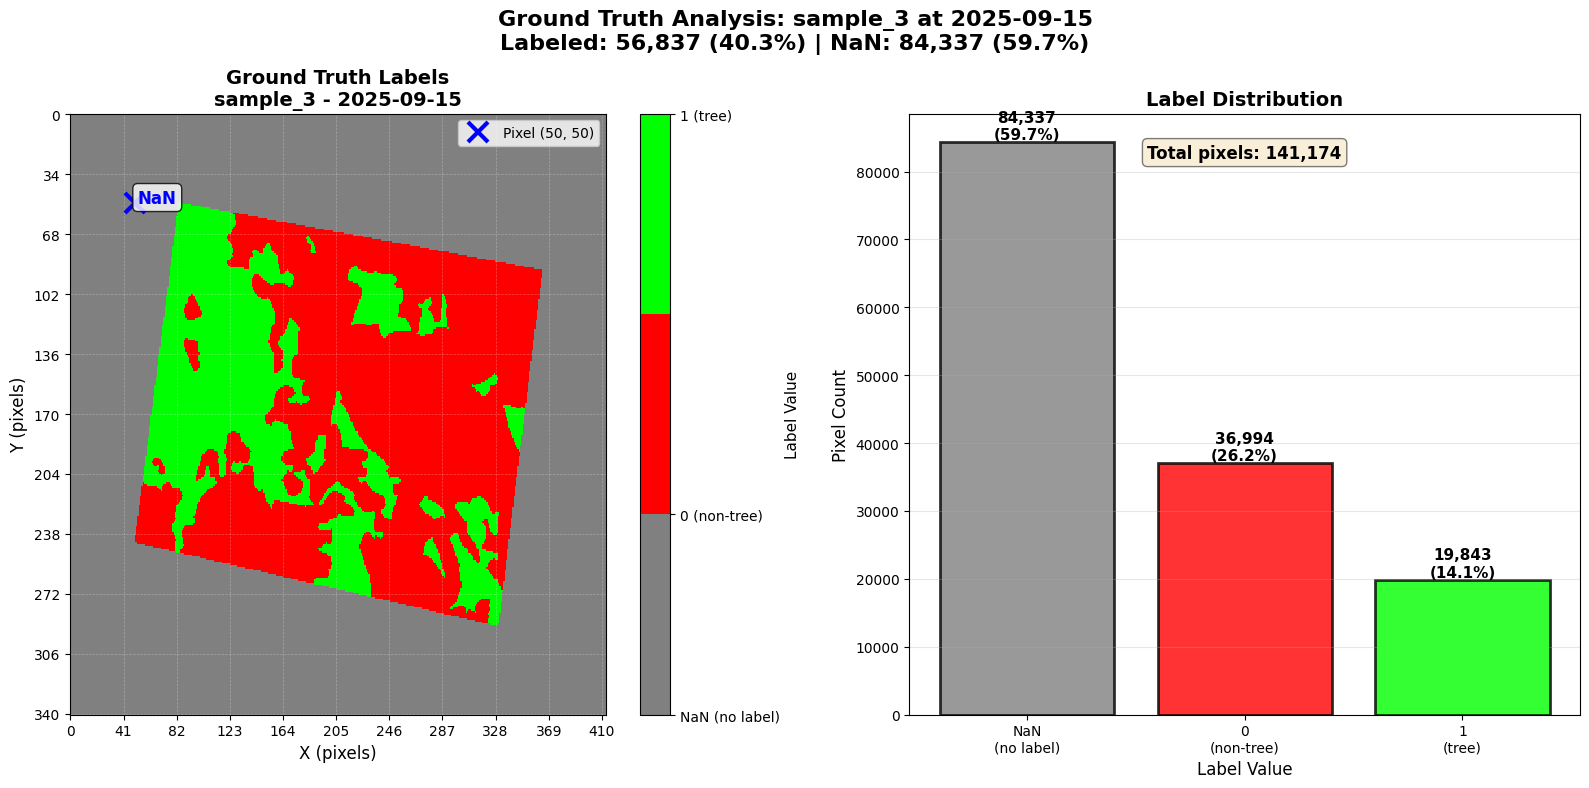


STATISTICS:
Total pixels: 141,174
  NaN (no label): 84,337 (59.74%)
  0 (non-tree):   36,994 (26.20%)
  1 (tree):       19,843 (14.06%)

Labeled pixels: 56,837 (40.26%)


In [131]:
# ============================================================================
# VISUALIZE: Ground Truth Labels Only (1, 0, NaN)
# ============================================================================
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np

plot_name = 'sample_3'
time_str = '2025-09-15'

print("=" * 60)
print(f"VISUALIZING GROUND TRUTH: {plot_name} at {time_str}")
print("=" * 60)

ds = gt

# Get ground truth slice
gt_slice = ds['ground_truth'].sel(plot_id=plot_name, time=time_str)

# Prepare data for visualization
gt_values = gt_slice.values.copy()
# Map: NaN -> -1, 0 -> 0, 1 -> 2 (for colormap indexing)
gt_plot = np.full_like(gt_values, -1, dtype=float)
gt_plot[gt_values == 0] = 0
gt_plot[gt_values == 1] = 2
gt_plot[np.isnan(gt_values)] = -1

# Count values
values = gt_values.flatten()
n_nan = np.isnan(values).sum()
n_zeros = (values == 0).sum()
n_ones = (values == 1).sum()
n_total = len(values)

# Create custom colormap: NaN=gray, 0=red, 1=green
colors = ['#808080', '#FF0000', '#00FF00']  # gray, red, green
cmap_custom = ListedColormap(colors)

# Create figure
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot 1: Ground Truth Labels
ax1 = axes[0]
im1 = ax1.imshow(gt_plot, cmap=cmap_custom, vmin=-1, vmax=2, aspect='auto', interpolation='nearest')
ax1.set_title(f'Ground Truth Labels\n{plot_name} - {time_str}', fontsize=14, fontweight='bold')
ax1.set_xlabel('X (pixels)', fontsize=12)
ax1.set_ylabel('Y (pixels)', fontsize=12)

# Add grid
ax1.grid(True, alpha=0.3, linestyle='--', linewidth=0.5, color='white')
ax1.set_xticks(range(0, gt_slice.shape[1], max(1, gt_slice.shape[1]//10)))
ax1.set_yticks(range(0, gt_slice.shape[0], max(1, gt_slice.shape[0]//10)))

# Add colorbar
cbar1 = plt.colorbar(im1, ax=ax1, ticks=[-1, 0, 2])
cbar1.set_ticklabels(['NaN (no label)', '0 (non-tree)', '1 (tree)'])
cbar1.set_label('Label Value', fontsize=11)

# Mark specific pixel if checking
check_x, check_y = 50, 50
if 0 <= check_x < gt_slice.shape[1] and 0 <= check_y < gt_slice.shape[0]:
    ax1.plot(check_x, check_y, 'bx', markersize=15, markeredgewidth=3, 
             label=f'Pixel ({check_x}, {check_y})')
    pixel_val = gt_values[check_y, check_x]
    if np.isnan(pixel_val):
        label_text = 'NaN'
    else:
        label_text = f'{int(pixel_val)}'
    ax1.text(check_x + 2, check_y, label_text, color='blue', 
             fontsize=12, fontweight='bold', bbox=dict(boxstyle='round', 
             facecolor='white', alpha=0.8))
    ax1.legend(loc='upper right', fontsize=10)

# Plot 2: Statistics Bar Chart
ax2 = axes[1]
categories = ['NaN\n(no label)', '0\n(non-tree)', '1\n(tree)']
counts = [n_nan, n_zeros, n_ones]
colors_bar = ['#808080', '#FF0000', '#00FF00']
percentages = [100 * c / n_total for c in counts]

bars = ax2.bar(categories, counts, color=colors_bar, alpha=0.8, edgecolor='black', linewidth=2)
ax2.set_title('Label Distribution', fontsize=14, fontweight='bold')
ax2.set_ylabel('Pixel Count', fontsize=12)
ax2.set_xlabel('Label Value', fontsize=12)
ax2.grid(True, alpha=0.3, axis='y')

# Add percentage labels on bars
for bar, pct, count in zip(bars, percentages, counts):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(count):,}\n({pct:.1f}%)',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

# Add total count text
ax2.text(0.5, 0.95, f'Total pixels: {n_total:,}',
         transform=ax2.transAxes, ha='center', va='top',
         fontsize=12, fontweight='bold',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle(f'Ground Truth Analysis: {plot_name} at {time_str}\n'
             f'Labeled: {n_zeros + n_ones:,} ({100*(n_zeros+n_ones)/n_total:.1f}%) | '
             f'NaN: {n_nan:,} ({100*n_nan/n_total:.1f}%)',
             fontsize=16, fontweight='bold', y=0.98)

plt.tight_layout()
plt.show()

# Print statistics
print(f"\n" + "=" * 60)
print("STATISTICS:")
print("=" * 60)
print(f"Total pixels: {n_total:,}")
print(f"  NaN (no label): {n_nan:,} ({100*n_nan/n_total:.2f}%)")
print(f"  0 (non-tree):   {n_zeros:,} ({100*n_zeros/n_total:.2f}%)")
print(f"  1 (tree):       {n_ones:,} ({100*n_ones/n_total:.2f}%)")
print(f"\nLabeled pixels: {n_zeros + n_ones:,} ({100*(n_zeros+n_ones)/n_total:.2f}%)")


In [132]:
## check only gt_valid
# Quick random sampling
plot_name = 'sample_3'
time_str = '2025-09-15'
n_samples = 10

# Get valid pixels
gt_slice = ds['ground_truth'].sel(plot_id=plot_name, time=time_str)
valid_mask = ~np.isnan(gt_slice.values)
y_indices, x_indices = np.where(valid_mask)

# Random sample
random_idx = np.random.choice(len(y_indices), size=min(n_samples, len(y_indices)), replace=False)
sampled_y = y_indices[random_idx]
sampled_x = x_indices[random_idx]
sampled_gt = gt_slice.values[sampled_y, sampled_x]

# Get coordinates
x_coords = gt_slice.x.values[sampled_x]
y_coords = gt_slice.y.values[sampled_y]

# Results
for i, (x, y, gt, xc, yc) in enumerate(zip(sampled_x, sampled_y, sampled_gt, x_coords, y_coords)):
    label = 'tree' if gt == 1 else 'non-tree'
    print(f"Pixel {i+1}: ({x}, {y}) at ({xc:.2f}, {yc:.2f}) → GT={int(gt)} ({label})")


Pixel 1: (109, 102) at (583899.54, 9969526.12) → GT=1 (tree)
Pixel 2: (227, 201) at (585079.54, 9968536.12) → GT=0 (non-tree)
Pixel 3: (95, 198) at (583759.54, 9968566.12) → GT=1 (tree)
Pixel 4: (211, 246) at (584919.54, 9968086.12) → GT=1 (tree)
Pixel 5: (162, 187) at (584429.54, 9968676.12) → GT=1 (tree)
Pixel 6: (307, 84) at (585879.54, 9969706.12) → GT=0 (non-tree)
Pixel 7: (212, 182) at (584929.54, 9968726.12) → GT=1 (tree)
Pixel 8: (298, 199) at (585789.54, 9968556.12) → GT=0 (non-tree)
Pixel 9: (311, 109) at (585919.54, 9969456.12) → GT=0 (non-tree)
Pixel 10: (74, 190) at (583549.54, 9968646.12) → GT=1 (tree)


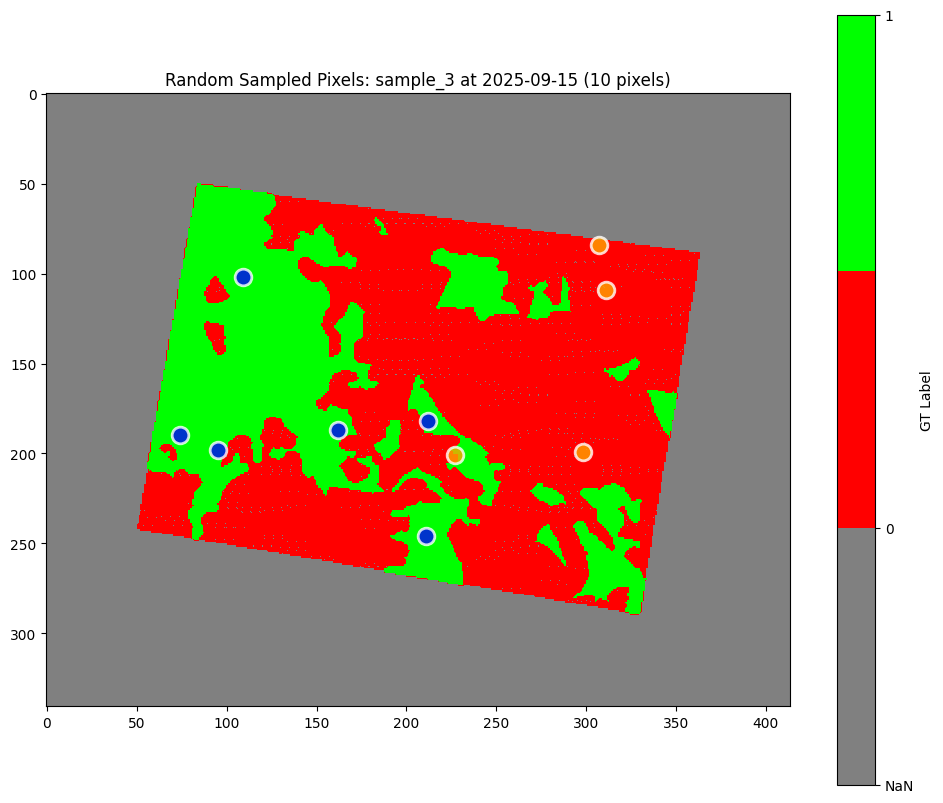

In [133]:
# Visualization (compact)
fig, ax = plt.subplots(figsize=(12, 10))
gt_plot = np.where(np.isnan(gt_slice.values), -1, np.where(gt_slice.values == 1, 2, 0))
ax.imshow(gt_plot, cmap=ListedColormap(['#808080', '#FF0000', '#00FF00']), vmin=-1, vmax=2, aspect='auto')
[ax.plot(x, y, 'o', markersize=12, markeredgecolor='white', markeredgewidth=2, 
         color='blue' if gt == 1 else 'orange', alpha=0.8) or 
 ax.text(x, y, f'{int(gt)}', color='white', fontsize=10, ha='center', va='center', fontweight='bold')
 for x, y, gt in zip(sampled_x, sampled_y, sampled_gt)]
ax.set_title(f'Random Sampled Pixels: {plot_name} at {time_str} ({len(sampled_x)} pixels)')
plt.colorbar(ax.imshow(gt_plot, cmap=ListedColormap(['#808080', '#FF0000', '#00FF00']), vmin=-1, vmax=2), 
             ax=ax, ticks=[-1, 0, 2], label='GT Label').set_ticklabels(['NaN', '0', '1'])
plt.show()

In [134]:
### lets check RAM usage
!free -h

               total        used        free      shared  buff/cache   available
Mem:            31Gi        12Gi        16Gi        16Mi       1.9Gi        18Gi
Swap:             0B          0B          0B


sample_3
sample_2
sample_1
RANDOM PIXEL TIMESERIES PLOTS:

Processing: sample_3
  Selected pixel: (y=279, x=302)
  Coordinates: (585829.54, 9967756.12)


  Timeseries: 93 time points, 39 labeled (6 tree, 33 non-tree)

Processing: sample_2
  Selected pixel: (y=162, x=73)
  Coordinates: (590059.54, 9950776.12)
  Timeseries: 93 time points, 67 labeled (0 tree, 67 non-tree)

Processing: sample_1
  Selected pixel: (y=145, x=147)
  Coordinates: (590249.54, 9953916.12)
  Timeseries: 90 time points, 36 labeled (36 tree, 0 non-tree)


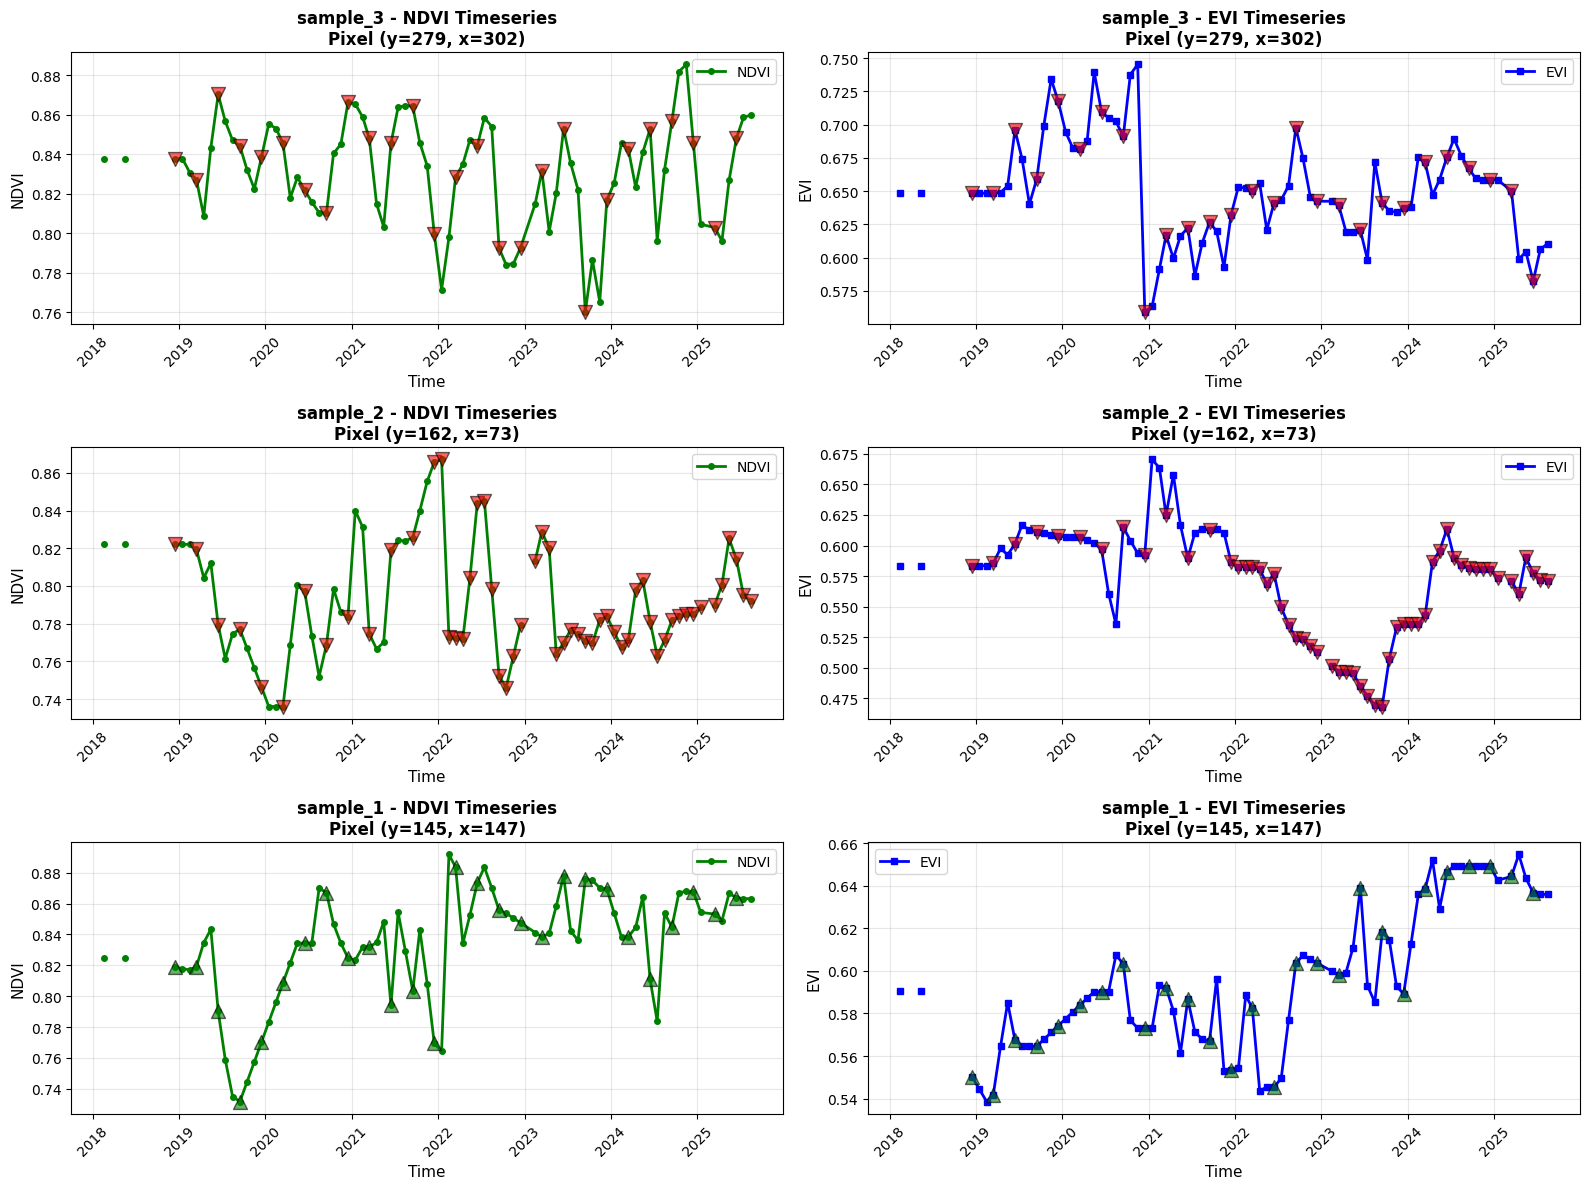


TIMESERIES PLOTS COMPLETE
Legend: Green triangle = tree (1), Red triangle = non-tree (0)


In [135]:
## visualization plot
for ds in ds_gt_list:
    print(ds.plot_id.item())  # Direct scalar extraction

# ============================================================================
# RANDOMLY SELECT VALID PIXEL AND PLOT TIMESERIES (NDVI, EVI) - FIXED
# ============================================================================
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

print("=" * 60)
print("RANDOM PIXEL TIMESERIES PLOTS:")
print("=" * 60)

# Create subplots for all datasets
n_datasets = len(ds_gt_list)
fig, axes = plt.subplots(n_datasets, 2, figsize=(16, 4 * n_datasets))

if n_datasets == 1:
    axes = axes.reshape(1, -1)

for idx, ds in enumerate(ds_gt_list):
    plot_id = ds.plot_id.item()
    print(f"\nProcessing: {plot_id}")
    
    # Get gt_valid (should be per plot, so select plot_id)
    if 'plot_id' in ds['gt_valid'].dims:
        valid_mask = ds['gt_valid'].sel(plot_id=plot_id).values
    else:
        valid_mask = ds['gt_valid'].values
    
    # Find valid pixels (where gt_valid is True)
    valid_indices = np.where(valid_mask)
    
    if len(valid_indices[0]) == 0:
        print(f"  ⚠️  No valid pixels found for {plot_id}")
        continue
    
    # Randomly select one valid pixel
    random_idx = np.random.choice(len(valid_indices[0]))
    y_idx = valid_indices[0][random_idx]
    x_idx = valid_indices[1][random_idx]
    
    print(f"  Selected pixel: (y={y_idx}, x={x_idx})")
    
    # Get coordinates
    x_coord = float(ds.x.isel(x=x_idx).values)
    y_coord = float(ds.y.isel(y=y_idx).values)
    print(f"  Coordinates: ({x_coord:.2f}, {y_coord:.2f})")
    
    # Extract timeseries for this pixel - ensure we get 1D arrays
    if 'plot_id' in ds['NDVI'].dims:
        ndvi_ts = ds['NDVI'].sel(plot_id=plot_id).isel(y=y_idx, x=x_idx)
        evi_ts = ds['EVI'].sel(plot_id=plot_id).isel(y=y_idx, x=x_idx)
        gt_ts = ds['ground_truth'].sel(plot_id=plot_id).isel(y=y_idx, x=x_idx)
    else:
        ndvi_ts = ds['NDVI'].isel(y=y_idx, x=x_idx)
        evi_ts = ds['EVI'].isel(y=y_idx, x=x_idx)
        gt_ts = ds['ground_truth'].isel(y=y_idx, x=x_idx)
    
    # Convert to numpy arrays and ensure 1D
    time_values = pd.to_datetime(ndvi_ts.time.values)
    ndvi_values = np.atleast_1d(ndvi_ts.values).flatten()  # Ensure 1D
    evi_values = np.atleast_1d(evi_ts.values).flatten()    # Ensure 1D
    gt_values = np.atleast_1d(gt_ts.values).flatten()      # Ensure 1D
    
    # Plot NDVI
    ax1 = axes[idx, 0]
    ax1.plot(time_values, ndvi_values, 'g-', linewidth=2, label='NDVI', marker='o', markersize=4)
    ax1.set_title(f'{plot_id} - NDVI Timeseries\nPixel (y={y_idx}, x={x_idx})', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Time', fontsize=11)
    ax1.set_ylabel('NDVI', fontsize=11)
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    ax1.tick_params(axis='x', rotation=45)
    
    # Add ground truth labels as colored markers - FIXED
    for i, (t, gt_val) in enumerate(zip(time_values, gt_values)):
        # Convert to scalar if needed
        gt_scalar = float(gt_val) if not isinstance(gt_val, (list, np.ndarray)) else float(gt_val[0])
        
        if not np.isnan(gt_scalar):
            color = 'green' if gt_scalar == 1 else 'red'
            marker = '^' if gt_scalar == 1 else 'v'
            # Find corresponding NDVI value
            ndvi_val = ndvi_values[i]
            ax1.scatter(t, ndvi_val, color=color, marker=marker, s=100, 
                       alpha=0.6, edgecolors='black', linewidth=1, zorder=5)
    
    # Plot EVI
    ax2 = axes[idx, 1]
    ax2.plot(time_values, evi_values, 'b-', linewidth=2, label='EVI', marker='s', markersize=4)
    ax2.set_title(f'{plot_id} - EVI Timeseries\nPixel (y={y_idx}, x={x_idx})', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Time', fontsize=11)
    ax2.set_ylabel('EVI', fontsize=11)
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    ax2.tick_params(axis='x', rotation=45)
    
    # Add ground truth labels as colored markers - FIXED
    for i, (t, gt_val) in enumerate(zip(time_values, gt_values)):
        # Convert to scalar if needed
        gt_scalar = float(gt_val) if not isinstance(gt_val, (list, np.ndarray)) else float(gt_val[0])
        
        if not np.isnan(gt_scalar):
            color = 'green' if gt_scalar == 1 else 'red'
            marker = '^' if gt_scalar == 1 else 'v'
            # Find corresponding EVI value
            evi_val = evi_values[i]
            ax2.scatter(t, evi_val, color=color, marker=marker, s=100, 
                       alpha=0.6, edgecolors='black', linewidth=1, zorder=5)
    
    # Print summary
    n_labeled = (~np.isnan(gt_values)).sum()
    n_trees = (gt_values == 1).sum()
    n_non_trees = (gt_values == 0).sum()
    print(f"  Timeseries: {len(time_values)} time points, {n_labeled} labeled ({n_trees} tree, {n_non_trees} non-tree)")

plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("TIMESERIES PLOTS COMPLETE")
print("=" * 60)
print("Legend: Green triangle = tree (1), Red triangle = non-tree (0)")

In [145]:
import os

### saving the xarray ds -> gt - sample groundtruth to the bucket
gcs_path_gt_root = 'gs://{os.getenv('GCS_BUCKET_PATH')}/01-korindo/timeseries_zarr/plots/gee'

for ds in ds_gt_list:
    plot_id = ds.plot_id.item()
    print(f'Saving dataset for sample_id: {plot_id}')
    
    # Drop image_id to avoid chunk alignment issues
    if 'image_id' in ds.data_vars: # problematic because we're not yet unchunk this, not needed for now
        ds = ds.drop_vars('image_id')
        print(f"  Dropped image_id variable")
    
    # Rechunk dataset
    ds_chunked = ds.chunk({
        'plot_id': 1,
        'time': 20,
        'x': 128,
        'y': 128
    })
    
    gcs_path = f'{gcs_path_gt_root}/{plot_id}_gt_pair_ds.zarr'
    
    # Save to GCS
    save_dataset_efficient_zarr(
        ds_chunked,
        gcs_path,
        chunk_sizes={'plot_id': 1, 'time': 40, 'x': 128, 'y': 128},
        compression='lz4',
        compression_level=1,
        overwrite=True,
        consolidated=True,
        storage='gcs',
        align_chunks=True
    )
    print(f'Saved dataset for sample_id: {plot_id}')


Saving dataset for sample_id: sample_3
🗑️  Removing existing GCS zarr store: gs://remote_sensing_saas/01-korindo/timeseries_zarr/plots/gee/sample_3_gt_pair_ds.zarr


📦 Saving to zarr: gs://remote_sensing_saas/01-korindo/timeseries_zarr/plots/gee/sample_3_gt_pair_ds.zarr
   Dimensions: {'time': 93, 'x': 414, 'y': 341, 'plot_id': 1}
   Chunks: {'plot_id': 1, 'time': 40, 'x': 128, 'y': 128}
   Compression: lz4 (level 1)
   Storage: gcs
💾 Writing to zarr (with automatic parallelism)...


/tmp/ipykernel_630/3711948572.py:113: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(f"   Dimensions: {dict(ds.dims)}")
/tmp/ipykernel_630/3711948572.py:141: FutureWarning: zarr_version is deprecated, use zarr_format
  ds_chunked.to_zarr(


[########################################] | 100% Completed | 8.13 ss
✅ Dataset saved successfully!
   Store size: 71.58 MB
   Time: 13.8 seconds (0.2 minutes)
   Write speed: 5.2 MB/s
   Path: gs://remote_sensing_saas/01-korindo/timeseries_zarr/plots/gee/sample_3_gt_pair_ds.zarr
Saved dataset for sample_id: sample_3
Saving dataset for sample_id: sample_2
📦 Saving to zarr: gs://remote_sensing_saas/01-korindo/timeseries_zarr/plots/gee/sample_2_gt_pair_ds.zarr
   Dimensions: {'time': 93, 'x': 413, 'y': 301, 'plot_id': 1}
   Chunks: {'plot_id': 1, 'time': 40, 'x': 128, 'y': 128}
   Compression: lz4 (level 1)
   Storage: gcs
💾 Writing to zarr (with automatic parallelism)...


/tmp/ipykernel_630/3711948572.py:113: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(f"   Dimensions: {dict(ds.dims)}")
/tmp/ipykernel_630/3711948572.py:141: FutureWarning: zarr_version is deprecated, use zarr_format
  ds_chunked.to_zarr(


[########################################] | 100% Completed | 4.91 sms
✅ Dataset saved successfully!
   Store size: 62.22 MB
   Time: 9.5 seconds (0.2 minutes)
   Write speed: 6.5 MB/s
   Path: gs://remote_sensing_saas/01-korindo/timeseries_zarr/plots/gee/sample_2_gt_pair_ds.zarr
Saved dataset for sample_id: sample_2
Saving dataset for sample_id: sample_1
📦 Saving to zarr: gs://remote_sensing_saas/01-korindo/timeseries_zarr/plots/gee/sample_1_gt_pair_ds.zarr
   Dimensions: {'time': 90, 'x': 322, 'y': 231, 'plot_id': 1}
   Chunks: {'plot_id': 1, 'time': 40, 'x': 128, 'y': 128}
   Compression: lz4 (level 1)
   Storage: gcs
💾 Writing to zarr (with automatic parallelism)...


/tmp/ipykernel_630/3711948572.py:113: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(f"   Dimensions: {dict(ds.dims)}")
/tmp/ipykernel_630/3711948572.py:141: FutureWarning: zarr_version is deprecated, use zarr_format
  ds_chunked.to_zarr(


[########################################] | 100% Completed | 6.04 sms
✅ Dataset saved successfully!
   Store size: 37.36 MB
   Time: 11.0 seconds (0.2 minutes)
   Write speed: 3.4 MB/s
   Path: gs://remote_sensing_saas/01-korindo/timeseries_zarr/plots/gee/sample_1_gt_pair_ds.zarr
Saved dataset for sample_id: sample_1


In [146]:
!free -h

               total        used        free      shared  buff/cache   available
Mem:            31Gi        12Gi        17Gi        16Mi       1.9Gi        18Gi
Swap:             0B          0B          0B


In [56]:
# ============================================================================
# CHECK Y-COORDINATE ORDERING IN ds_resampled
# ============================================================================
print("=" * 60)
print("CHECKING Y-COORDINATE ORDERING:")
print("=" * 60)

# Check y coordinate values
y_values = ds_resampled.y.values
y_min = float(y_values.min())
y_max = float(y_values.max())
y_first = float(y_values[0])
y_last = float(y_values[-1])

print(f"\nY-coordinate analysis:")
print(f"  First y value: {y_first:.2f}")
print(f"  Last y value: {y_last:.2f}")
print(f"  Min y value: {y_min:.2f}")
print(f"  Max y value: {y_max:.2f}")
print(f"  Number of y values: {len(y_values)}")

# Determine ordering
if y_first < y_last:
    y_order = "ASCENDING (increasing)"
    print(f"\n✓ Y-coordinates are {y_order}")
    print(f"  Use: y=slice(maxy, miny)  # Reversed for slice")
    correct_slice = "y=slice(maxy, miny)"
elif y_first > y_last:
    y_order = "DESCENDING (decreasing)"
    print(f"\n✓ Y-coordinates are {y_order}")
    print(f"  Use: y=slice(miny, maxy)  # Normal order")
    correct_slice = "y=slice(miny, maxy)"
else:
    y_order = "CONSTANT (all same)"
    print(f"\n⚠️  Y-coordinates are {y_order} - unusual!")

# Also check x coordinates for reference
x_values = ds_resampled.x.values
x_first = float(x_values[0])
x_last = float(x_values[-1])
print(f"\nX-coordinate (for reference):")
print(f"  First x: {x_first:.2f}, Last x: {x_last:.2f}")
if x_first < x_last:
    print(f"  X is ASCENDING (normal)")

# Test a small slice to verify
print(f"\n" + "=" * 60)
print("TESTING SLICE DIRECTION:")
print("=" * 60)

# Get sample bounds (use first sample for testing)
if 'training_gdf' in locals():
    sample_gdf = training_gdf[training_gdf['layer'] == training_gdf['layer'].iloc[0]]
    test_bounds = sample_gdf.total_bounds
    test_minx, test_miny, test_maxx, test_maxy = test_bounds
    
    print(f"\nTest bounds: [{test_minx:.0f}, {test_miny:.0f}, {test_maxx:.0f}, {test_maxy:.0f}]")
    
    # Test both slice directions
    try:
        # Test 1: slice(miny, maxy) - normal order
        print("\nTest 1: y=slice(miny, maxy)")
        test1 = ds_resampled.sel(x=slice(test_minx, test_maxx), y=slice(test_miny, test_maxy))
        print(f"  ✓ Success! Shape: {dict(test1.sizes)}")
        test1_result = "WORKS"
    except Exception as e:
        print(f"  ❌ Failed: {e}")
        test1_result = "FAILED"
    
    try:
        # Test 2: slice(maxy, miny) - reversed order
        print("\nTest 2: y=slice(maxy, miny)")
        test2 = ds_resampled.sel(x=slice(test_minx, test_maxx), y=slice(test_maxy, test_miny))
        print(f"  ✓ Success! Shape: {dict(test2.sizes)}")
        test2_result = "WORKS"
    except Exception as e:
        print(f"  ❌ Failed: {e}")
        test2_result = "FAILED"
    
    # Determine which is correct
    print(f"\n" + "=" * 60)
    print("RECOMMENDATION:")
    print("=" * 60)
    
    if test1_result == "WORKS" and test2_result == "FAILED":
        print("✓ Use: y=slice(miny, maxy)  (normal order)")
        recommended = "y=slice(miny, maxy)"
    elif test1_result == "FAILED" and test2_result == "WORKS":
        print("✓ Use: y=slice(maxy, miny)  (reversed order)")
        recommended = "y=slice(maxy, miny)"
    elif test1_result == "WORKS" and test2_result == "WORKS":
        # Both work, check which gives non-zero result
        if test1.sizes['y'] > 0 and test2.sizes['y'] > 0:
            print("⚠️  Both work! Check which gives correct extent:")
            print(f"  slice(miny, maxy): {test1.sizes['y']} y pixels")
            print(f"  slice(maxy, miny): {test2.sizes['y']} y pixels")
            # The one with more pixels is likely correct
            if test1.sizes['y'] >= test2.sizes['y']:
                recommended = "y=slice(miny, maxy)"
                print(f"  → Recommend: y=slice(miny, maxy)")
            else:
                recommended = "y=slice(maxy, miny)"
                print(f"  → Recommend: y=slice(maxy, miny)")
        else:
            print("⚠️  Both work but one gives zero size - use the non-zero one")
            recommended = "y=slice(miny, maxy)" if test1.sizes['y'] > 0 else "y=slice(maxy, miny)"
    else:
        print("❌ Neither works - check coordinate alignment!")
        recommended = None
    
    print(f"\nUse this in your code:")
    print(f"  ds_clipped = ds_resampled.sel(")
    print(f"      x=slice(minx, maxx),")
    print(f"      {recommended}")
    print(f"  )")
else:
    print("\n⚠️  training_gdf not found - skipping slice test")
    print(f"Based on y-coordinate order, use: {correct_slice}")

CHECKING Y-COORDINATE ORDERING:

Y-coordinate analysis:
  First y value: 9949396.12
  Last y value: 9981516.12
  Min y value: 9949396.12
  Max y value: 9981516.12
  Number of y values: 3213

✓ Y-coordinates are ASCENDING (increasing)
  Use: y=slice(maxy, miny)  # Reversed for slice

X-coordinate (for reference):
  First x: 578619.54, Last x: 623499.54
  X is ASCENDING (normal)

TESTING SLICE DIRECTION:

Test bounds: [583303, 9967645, 586447, 9970049]

Test 1: y=slice(miny, maxy)
  ✓ Success! Shape: {'time': 81, 'x': 314, 'y': 241}

Test 2: y=slice(maxy, miny)
  ✓ Success! Shape: {'time': 81, 'x': 314, 'y': 0}

RECOMMENDATION:
⚠️  Both work but one gives zero size - use the non-zero one

Use this in your code:
  ds_clipped = ds_resampled.sel(
      x=slice(minx, maxx),
      y=slice(miny, maxy)
  )
